In [1]:
import collections
# Prepare paths to local utilities
import os
import sys

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [2]:
is_kaggle = (os.environ.get("PWD", "") == "/kaggle/working")
print(f"Are we running in Kaggle? {is_kaggle}")

Are we running in Kaggle? False


In [3]:
if not is_kaggle:
    models_path = os.path.abspath(os.path.join('..', 'model'))
    utils_path = os.path.abspath(os.path.join('..', 'util'))
    sys.path.append(models_path)
    sys.path.append(utils_path)

    %load_ext autoreload
    %autoreload 2

    from download.DataDownloader import DataDownloader
    from collect.DataframeCollector import DataframeCollector
    from collect.TestSetSplitter import TestSetSplitter
    from collect.DatasetPreparation import DatasetPreparation
    from processing.DataPreprocessor import DataPreprocessor
    from reservoir.BasicESNCuda import BasicESNCuda as BasicESN
    from reservoir.ESNUtil import generate_input_weights

else:
    from datadownloader.datadownloader import DataDownloader
    from dataframecollector.dataframecollector import DataframeCollector
    from testsetsplitter.testsetsplitter import TestSetSplitter
    from datasetpreparation.datasetpreparation import DatasetPreparation
    from datapreprocessor.datapreprocessor import DataPreprocessor
    from basicesncuda.basicesncuda import BasicESNCuda as BasicESN
    from esnutil.esnutil import generate_input_weights

In [4]:
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [5]:
data_preparation = DatasetPreparation()

input_features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
output_features = ['label']

data_preparation.prepare_dataset('har70plus', input_features, output_features)

Dataset already downloaded
Discovered  18  csv files in  E:\PyCharm\COM6906-Dissertation\data\har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes
Data shape:  [(103860, 9), (131367, 9), (116413, 9), (150758, 9), (87006, 9), (122714, 9), (120125, 9), (130494, 9), (121763, 9), (122061, 9), (128063, 9), (119310, 9), (123599, 9), (101510, 9), (153517, 9), (138278, 9), (147045, 9), (141714, 9)]
Number of frames in training set: 17
Number of frames in validation set: 17
Number of frames in testing set: 18
X_train shape: (1357646, 6), Y_train shape: (1357646,)
X_val shape: (339404, 6), Y_val shape: (339404,)
X_test shape: (562547, 6), Y_test shape: (562547,)
Y_train encoded shape: (1357646, 7)
Y_val encoded shape: (339404, 7)
Y_test encoded shape: (562547, 7)
Y_train decoded shape: (1357646, 1)
Y_val decoded shape: (339404, 1)
Y_test decoded shape: (562547, 1)
X_train scaled shape: (1357646, 6)
X_val scaled shape: (339404, 6)
X_test scaled shape

In [6]:
X_train_scaled, y_train_encoded = data_preparation.get_preprocessed_data('train')
X_val_scaled, y_val_encoded = data_preparation.get_preprocessed_data('val')
X_test_scaled, y_test_encoded = data_preparation.get_preprocessed_data('test')

In [7]:
data_preprocessor = DataPreprocessor()

# The data preprocessor object provides access to different data preprocessing methods
# The available methods are:
# - buffered_windows(window_size, x, y)
# - exponential_moving_average(alpha, x, y)
# - fourier_smoothing(x, threshold)
# - pipeline(step_names, x, y)
# - get_available_steps()

In [8]:
# As a test, we will start by taking the optimal hyperparameter set from the basicESN testing and see whether this needs to be adjusted once the data is preprocessed

# The optimal hyperparameters were:
n_neurons = 500
density = 0.2
leakage = 0.8
spectral_radius = 0.999
gamma = 0.999
sparsity = 0.8
input_weight_type = 'uniform'

# We will first try using each preprocessing method separately to see if any of them improve the performance, and then attempt a few pipelines to see if a combination of methods can improve the performance

In [11]:
run_windows_optimal = False

In [12]:
# First, we will try the buffered_windows method

if run_windows_optimal:
    window_sizes = [10, 50, 100, 500, 1000]

    window_scores = []

    for window_size in window_sizes:
        x_train_windowed, y_train_windowed = data_preprocessor.buffered_windows(window_size, X_train_scaled,
                                                                                y_train_encoded)
        x_val_windowed, y_val_windowed = data_preprocessor.buffered_windows(window_size, X_val_scaled, y_val_encoded)
        x_test_windowed, y_test_windowed = data_preprocessor.buffered_windows(window_size, X_test_scaled,
                                                                              y_test_encoded)

        # Generate input weights has parameters n_neurons, n_features, density, input_weight_type
        input_weights = generate_input_weights(n_neurons, x_train_windowed.shape[1], density, input_weight_type)

        basic_esn = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius, gamma=gamma,
                             sparsity=sparsity, W_in=input_weights)

        basic_esn.fit(x_train_windowed, y_train_windowed, x_val=x_val_windowed, y_val=y_val_windowed)

        y_pred = basic_esn.forward(x_test_windowed)

        # Before we can score the model, we need to decode the one-hot encoded labels
        # As we are using windowed data, we first need to reshape the data from (n_samples//window_size, n_classes * window_size) to (n_samples, n_classes)
        # And then we need to pass the reshaped data through the inverse_transform of data_preparation.get_encoder()
        y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[1] // window_size)
        y_test_reshaped = y_test_windowed.reshape(-1, y_test_windowed.shape[1] // window_size)

        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_reshaped)
        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_reshaped)

        # Calculate the NMRSE score
        nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                y_test_decoded.max() - y_test_decoded.min())

        window_scores.append({'window_size': window_size, 'nmrse': nrmse})

else:
    window_scores = [{'window_size': 10, 'nmrse': 0.22265595636765426},
                     {'window_size': 50, 'nmrse': 0.29042612208841645},
                     {'window_size': 100, 'nmrse': 0.319750867928468},
                     {'window_size': 500, 'nmrse': 0.38193383574668005},
                     {'window_size': 1000, 'nmrse': 0.391577001289972}]

In [13]:
print(window_scores)

[{'window_size': 10, 'nmrse': 0.22265595636765426}, {'window_size': 50, 'nmrse': 0.29042612208841645}, {'window_size': 100, 'nmrse': 0.319750867928468}, {'window_size': 500, 'nmrse': 0.38193383574668005}, {'window_size': 1000, 'nmrse': 0.391577001289972}]


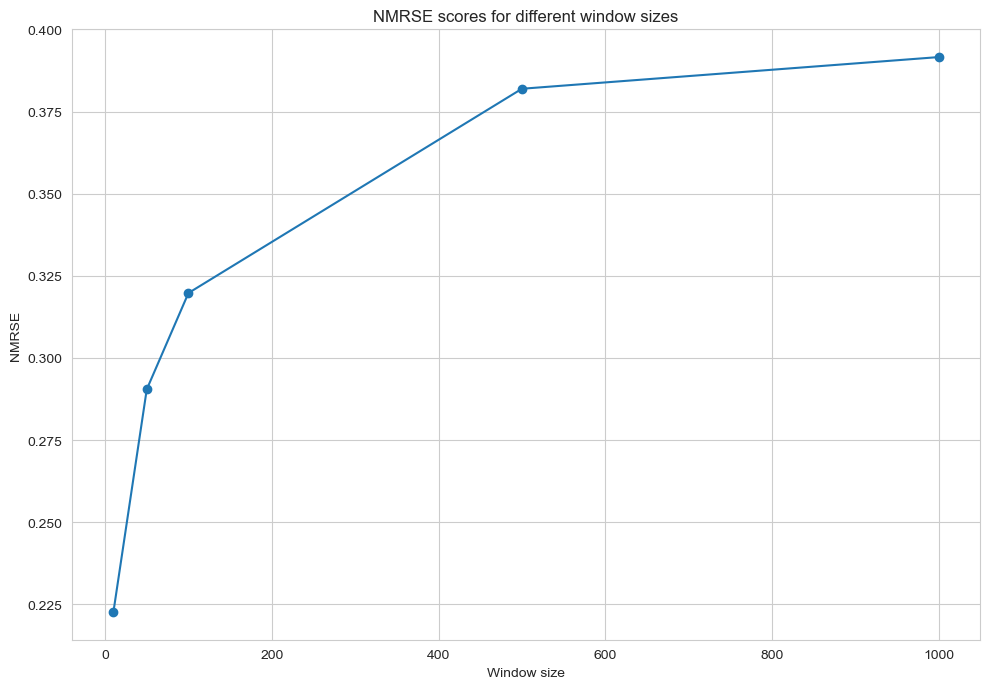

In [14]:
# Let's plot the results to see if there is a clear winner
sizes = [score['window_size'] for score in window_scores]
nmrse = [score['nmrse'] for score in window_scores]

plt.figure(figsize=(10, 7))
plt.plot(sizes, nmrse, marker='o')
plt.xlabel('Window size')
plt.ylabel('NMRSE')
plt.title('NMRSE scores for different window sizes')

plt.tight_layout()
plt.show()

In [15]:
# Get the best window size
best_window_optimal = window_scores[np.argmin(nmrse)]['window_size']

print(f"Best Window Size: {best_window_optimal}")

Best Window Size: 10


In [16]:
run_emas_optimal = False

In [17]:
# Now we will try the exponential_moving_average method

if run_emas_optimal:
    alphas = [0.001, 0.01, 0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]

    ema_scores = []

    for alpha in alphas:
        x_train_ema, y_train_ema = data_preprocessor.exponential_moving_average(alpha, X_train_scaled, y_train_encoded)
        x_val_ema, y_val_ema = data_preprocessor.exponential_moving_average(alpha, X_val_scaled, y_val_encoded)
        x_test_ema, y_test_ema = data_preprocessor.exponential_moving_average(alpha, X_test_scaled, y_test_encoded)

        input_weights = generate_input_weights(n_neurons, x_train_ema.shape[1], density, input_weight_type)

        basic_esn = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius, gamma=gamma,
                             sparsity=sparsity, W_in=input_weights, class_weights=data_preparation.get_class_weights())

        basic_esn.fit(x_train_ema, y_train_ema, x_val=x_val_ema, y_val=y_val_ema)

        y_pred = basic_esn.forward(x_test_ema)

        # Before we can score the model, we need to decode the one-hot encoded labels
        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)
        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_ema)

        # Calculate the NMRSE score
        nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                y_test_decoded.max() - y_test_decoded.min())

        ema_scores.append({'alpha': alpha, 'nmrse': nrmse})

else:
    ema_scores = [{'alpha': 0.001, 'nmrse': 0.25577295332624844}, {'alpha': 0.01, 'nmrse': 0.24683433791492262},
                  {'alpha': 0.1, 'nmrse': 0.24636975786767631}, {'alpha': 0.5, 'nmrse': 0.2514625787545563},
                  {'alpha': 0.7, 'nmrse': 0.2484534540576421}, {'alpha': 0.8, 'nmrse': 0.2480578010511014},
                  {'alpha': 0.9, 'nmrse': 0.2458151023205218}, {'alpha': 0.95, 'nmrse': 0.241183253665914},
                  {'alpha': 0.99, 'nmrse': 0.2481419529433462}, {'alpha': 0.999, 'nmrse': 0.23720339029842488}]

In [18]:
print(ema_scores)

[{'alpha': 0.001, 'nmrse': 0.25577295332624844}, {'alpha': 0.01, 'nmrse': 0.24683433791492262}, {'alpha': 0.1, 'nmrse': 0.24636975786767631}, {'alpha': 0.5, 'nmrse': 0.2514625787545563}, {'alpha': 0.7, 'nmrse': 0.2484534540576421}, {'alpha': 0.8, 'nmrse': 0.2480578010511014}, {'alpha': 0.9, 'nmrse': 0.2458151023205218}, {'alpha': 0.95, 'nmrse': 0.241183253665914}, {'alpha': 0.99, 'nmrse': 0.2481419529433462}, {'alpha': 0.999, 'nmrse': 0.23720339029842488}]


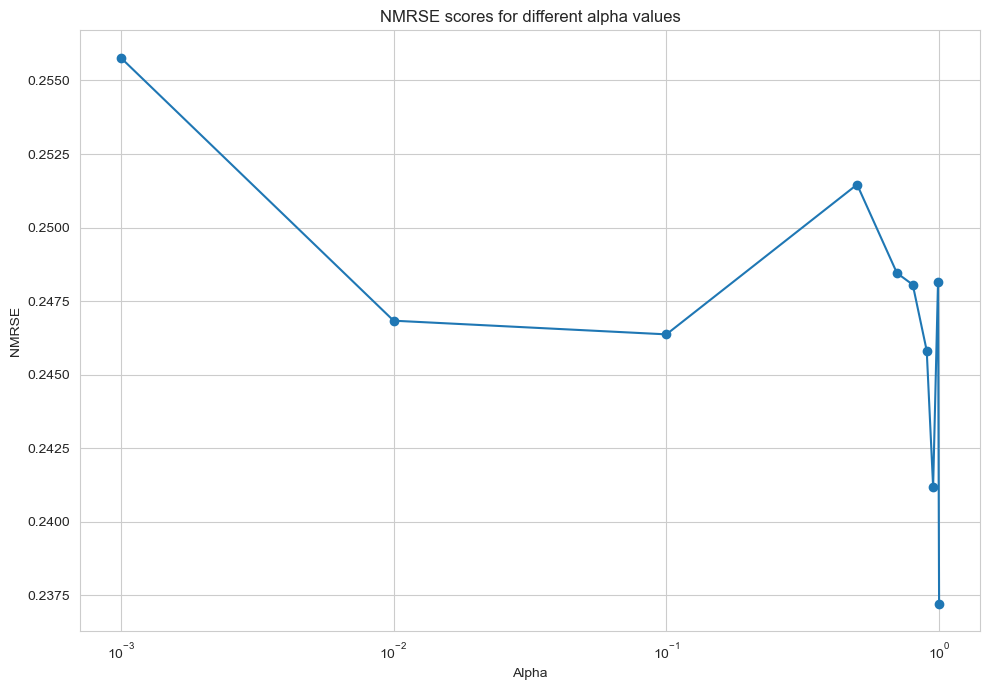

In [19]:
# Let's plot the results to see if there is a clear winner
alphas = [score['alpha'] for score in ema_scores]
nmrse = [score['nmrse'] for score in ema_scores]

plt.figure(figsize=(10, 7))

plt.plot(alphas, nmrse, marker='o')
plt.xlabel('Alpha')
plt.ylabel('NMRSE')
plt.title('NMRSE scores for different alpha values')
plt.xscale('log')

plt.tight_layout()
plt.show()

In [20]:
# Get the best alpha
best_alpha_optimal = ema_scores[np.argmin(nmrse)]['alpha']

print(f"Best EMA Alpha: {best_alpha_optimal}")

Best EMA Alpha: 0.999


In [21]:
run_fourier_optimal = False

In [22]:
# Now we will try the fourier_smoothing method

if run_fourier_optimal:
    thresholds = [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

    fourier_scores = []

    for threshold in thresholds:
        x_train_fourier = data_preprocessor.fourier_smoothing(X_train_scaled, threshold)
        x_val_fourier = data_preprocessor.fourier_smoothing(X_val_scaled, threshold)
        x_test_fourier = data_preprocessor.fourier_smoothing(X_test_scaled, threshold)

        input_weights = generate_input_weights(n_neurons, x_train_fourier.shape[1], density, input_weight_type)

        basic_esn = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius, gamma=gamma,
                             sparsity=sparsity, W_in=input_weights, class_weights=data_preparation.get_class_weights())

        basic_esn.fit(x_train_fourier, y_train_encoded, x_val=x_val_fourier, y_val=y_val_encoded)

        y_pred = basic_esn.forward(x_test_fourier)

        # Before we can score the model, we need to decode the one-hot encoded labels
        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)
        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)

        # Calculate the NMRSE score
        nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                y_test_decoded.max() - y_test_decoded.min())

        fourier_scores.append({'threshold': threshold, 'nmrse': nrmse})

else:
    fourier_scores = [{'threshold': 1000.0, 'nmrse': 0.2562997619214603},
                      {'threshold': 100.0, 'nmrse': 0.2576819098290108},
                      {'threshold': 10.0, 'nmrse': 0.2563173837643941},
                      {'threshold': 1.0, 'nmrse': 0.24849645201146137}, {'threshold': 0.1, 'nmrse': 0.2261314397229505},
                      {'threshold': 0.01, 'nmrse': 0.31659739514752616},
                      {'threshold': 0.001, 'nmrse': 0.3844482746039507},
                      {'threshold': 0.0001, 'nmrse': 0.4379391152907871},
                      {'threshold': 1e-05, 'nmrse': 0.4692323611136562}]

In [23]:
print(fourier_scores)

[{'threshold': 1000.0, 'nmrse': 0.2562997619214603}, {'threshold': 100.0, 'nmrse': 0.2576819098290108}, {'threshold': 10.0, 'nmrse': 0.2563173837643941}, {'threshold': 1.0, 'nmrse': 0.24849645201146137}, {'threshold': 0.1, 'nmrse': 0.2261314397229505}, {'threshold': 0.01, 'nmrse': 0.31659739514752616}, {'threshold': 0.001, 'nmrse': 0.3844482746039507}, {'threshold': 0.0001, 'nmrse': 0.4379391152907871}, {'threshold': 1e-05, 'nmrse': 0.4692323611136562}]


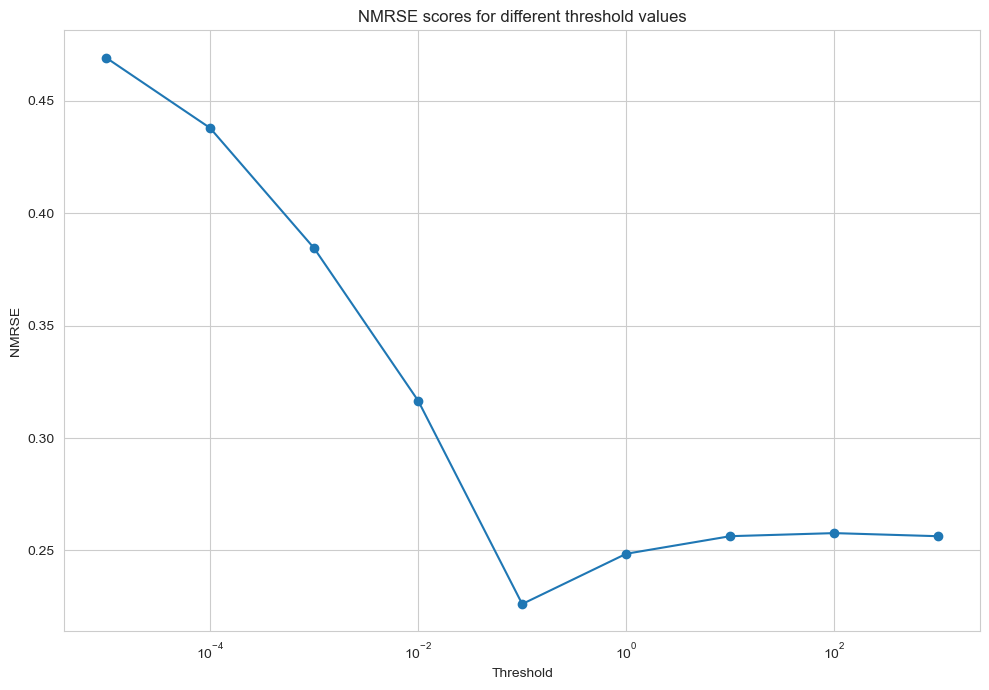

In [24]:
# Let's plot the results to see if there is a clear winner
thresholds = [score['threshold'] for score in fourier_scores]
nmrse = [score['nmrse'] for score in fourier_scores]

plt.figure(figsize=(10, 7))

plt.plot(thresholds, nmrse, marker='o')
plt.xlabel('Threshold')
plt.ylabel('NMRSE')
plt.title('NMRSE scores for different threshold values')
plt.xscale('log')

plt.tight_layout()
plt.show()

In [25]:
# Get the best threshold
best_threshold_optimal = fourier_scores[np.argmin(nmrse)]['threshold']

print(f"Best Fourier Threshold: {best_threshold_optimal}")

Best Fourier Threshold: 0.1


In [26]:
# As with the ridge baseline, let's try combining fourier smoothing with a windowing method
run_windows_fourier_optimal = False

In [27]:
if run_windows_fourier_optimal:
    window_sizes = [10, 50, 100, 500, 1000]
    thresholds = [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

    pipeline_steps = ['buffered_windows', 'fourier_smoothing']

    window_fourier_scores = []

    for window_size in window_sizes:
        for threshold in thresholds:
            pipeline_params = [window_size, threshold]

            x_train_windowed_fourier, y_train_windowed_fourier = data_preprocessor.pipeline(pipeline_steps,
                                                                                            X_train_scaled,
                                                                                            y_train_encoded,
                                                                                            pipeline_params)

            x_val_windowed_fourier, y_val_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_val_scaled,
                                                                                        y_val_encoded, pipeline_params)

            x_test_windowed_fourier, y_test_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_test_scaled,
                                                                                          y_test_encoded,
                                                                                          pipeline_params)

            input_weights = generate_input_weights(n_neurons, x_train_windowed_fourier.shape[1], density,
                                                   input_weight_type)

            basic_esn = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius,
                                 gamma=gamma, sparsity=sparsity, W_in=input_weights,
                                 class_weights=data_preparation.get_class_weights())

            basic_esn.fit(x_train_windowed_fourier, y_train_windowed_fourier, x_val=x_val_windowed_fourier,
                          y_val=y_val_windowed_fourier)

            y_pred = basic_esn.forward(x_test_windowed_fourier)

            # Before we can score the model, we need to decode the one-hot encoded labels
            # As we are using windowed data, we first need to reshape the data from (n_samples//window_size, n_classes * window_size) to (n_samples, n_classes)
            # And then we need to pass the reshaped data through the inverse_transform of data_preparation.get_encoder()
            y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[1] // window_size)
            y_test_reshaped = y_test_windowed_fourier.reshape(-1, y_test_windowed_fourier.shape[1] // window_size)

            y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_reshaped)
            y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_reshaped)

            # Calculate the NMRSE score
            nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                    y_test_decoded.max() - y_test_decoded.min())

            window_fourier_scores.append({'window_size': window_size, 'threshold': threshold, 'nmrse': nrmse})

else:
    window_fourier_scores = [{'window_size': 10, 'threshold': 1000.0, 'nmrse': 0.2853287900540981},
                             {'window_size': 10, 'threshold': 100.0, 'nmrse': 0.2789865239780679},
                             {'window_size': 10, 'threshold': 10.0, 'nmrse': 0.29319770432849035},
                             {'window_size': 10, 'threshold': 1.0, 'nmrse': 0.2798729931720429},
                             {'window_size': 10, 'threshold': 0.1, 'nmrse': 0.3116976248146437},
                             {'window_size': 10, 'threshold': 0.01, 'nmrse': 0.35329488676319437},
                             {'window_size': 10, 'threshold': 0.001, 'nmrse': 0.44391926672708576},
                             {'window_size': 10, 'threshold': 0.0001, 'nmrse': 0.4597445078001562},
                             {'window_size': 10, 'threshold': 1e-05, 'nmrse': 0.3596832589206399},
                             {'window_size': 50, 'threshold': 1000.0, 'nmrse': 0.3172134610537775},
                             {'window_size': 50, 'threshold': 100.0, 'nmrse': 0.3139550646780654},
                             {'window_size': 50, 'threshold': 10.0, 'nmrse': 0.3169463647125123},
                             {'window_size': 50, 'threshold': 1.0, 'nmrse': 0.3198200969356743},
                             {'window_size': 50, 'threshold': 0.1, 'nmrse': 0.378828479272364},
                             {'window_size': 50, 'threshold': 0.01, 'nmrse': 0.4497008745041486},
                             {'window_size': 50, 'threshold': 0.001, 'nmrse': 0.4491369512192049},
                             {'window_size': 50, 'threshold': 0.0001, 'nmrse': 0.44486721005849045},
                             {'window_size': 50, 'threshold': 1e-05, 'nmrse': 0.5691745799385438},
                             {'window_size': 100, 'threshold': 1000.0, 'nmrse': 0.3358416283150872},
                             {'window_size': 100, 'threshold': 100.0, 'nmrse': 0.33749150052214116},
                             {'window_size': 100, 'threshold': 10.0, 'nmrse': 0.32489067608408106},
                             {'window_size': 100, 'threshold': 1.0, 'nmrse': 0.3158158007223917},
                             {'window_size': 100, 'threshold': 0.1, 'nmrse': 0.4421357002681729},
                             {'window_size': 100, 'threshold': 0.01, 'nmrse': 0.49805901688775667},
                             {'window_size': 100, 'threshold': 0.001, 'nmrse': 0.4437725724625122},
                             {'window_size': 100, 'threshold': 0.0001, 'nmrse': 0.4443966403438933},
                             {'window_size': 100, 'threshold': 1e-05, 'nmrse': 0.8098323992283787},
                             {'window_size': 500, 'threshold': 1000.0, 'nmrse': 0.4015791047339253},
                             {'window_size': 500, 'threshold': 100.0, 'nmrse': 0.3865209079670161},
                             {'window_size': 500, 'threshold': 10.0, 'nmrse': 0.3918577169923759},
                             {'window_size': 500, 'threshold': 1.0, 'nmrse': 0.3989483038655656},
                             {'window_size': 500, 'threshold': 0.1, 'nmrse': 0.4423761210461257},
                             {'window_size': 500, 'threshold': 0.01, 'nmrse': 0.4740366753378635},
                             {'window_size': 500, 'threshold': 0.001, 'nmrse': 0.4729651704813907},
                             {'window_size': 500, 'threshold': 0.0001, 'nmrse': 0.7406112478761454},
                             {'window_size': 500, 'threshold': 1e-05, 'nmrse': 0.5658577090535012},
                             {'window_size': 1000, 'threshold': 1000.0, 'nmrse': 0.39826776294998273},
                             {'window_size': 1000, 'threshold': 100.0, 'nmrse': 0.42351444281288203},
                             {'window_size': 1000, 'threshold': 10.0, 'nmrse': 0.41407212161409207},
                             {'window_size': 1000, 'threshold': 1.0, 'nmrse': 0.408560746396236},
                             {'window_size': 1000, 'threshold': 0.1, 'nmrse': 0.45899013816369266},
                             {'window_size': 1000, 'threshold': 0.01, 'nmrse': 0.5345250947187041},
                             {'window_size': 1000, 'threshold': 0.001, 'nmrse': 0.48929046036255924},
                             {'window_size': 1000, 'threshold': 0.0001, 'nmrse': 0.5158023395676504},
                             {'window_size': 1000, 'threshold': 1e-05, 'nmrse': 0.6832726607885331}]

In [28]:
print(window_fourier_scores)

[{'window_size': 10, 'threshold': 1000.0, 'nmrse': 0.2853287900540981}, {'window_size': 10, 'threshold': 100.0, 'nmrse': 0.2789865239780679}, {'window_size': 10, 'threshold': 10.0, 'nmrse': 0.29319770432849035}, {'window_size': 10, 'threshold': 1.0, 'nmrse': 0.2798729931720429}, {'window_size': 10, 'threshold': 0.1, 'nmrse': 0.3116976248146437}, {'window_size': 10, 'threshold': 0.01, 'nmrse': 0.35329488676319437}, {'window_size': 10, 'threshold': 0.001, 'nmrse': 0.44391926672708576}, {'window_size': 10, 'threshold': 0.0001, 'nmrse': 0.4597445078001562}, {'window_size': 10, 'threshold': 1e-05, 'nmrse': 0.3596832589206399}, {'window_size': 50, 'threshold': 1000.0, 'nmrse': 0.3172134610537775}, {'window_size': 50, 'threshold': 100.0, 'nmrse': 0.3139550646780654}, {'window_size': 50, 'threshold': 10.0, 'nmrse': 0.3169463647125123}, {'window_size': 50, 'threshold': 1.0, 'nmrse': 0.3198200969356743}, {'window_size': 50, 'threshold': 0.1, 'nmrse': 0.378828479272364}, {'window_size': 50, 'thre

In [29]:
# Get the best window size and threshold
best_window_fourier_optimal = window_fourier_scores[np.argmin([score['nmrse'] for score in window_fourier_scores])]
best_window_size_optimal = best_window_fourier_optimal['window_size']
best_threshold_fourier_optimal = best_window_fourier_optimal['threshold']

print(f"Best Window Size: {best_window_size_optimal}")
print(f"Best Fourier Threshold: {best_threshold_fourier_optimal}")

Best Window Size: 10
Best Fourier Threshold: 100.0


In [30]:
# Now that we have tried each preprocessing method separately, let's train each of the best models and compare the results

# First, we will train the model with the best window size
x_train_windowed, y_train_windowed = data_preprocessor.buffered_windows(best_window_optimal, X_train_scaled,
                                                                        y_train_encoded)
x_val_windowed, y_val_windowed = data_preprocessor.buffered_windows(best_window_optimal, X_val_scaled, y_val_encoded)
x_test_windowed, y_test_windowed = data_preprocessor.buffered_windows(best_window_optimal, X_test_scaled,
                                                                      y_test_encoded)

input_weights = generate_input_weights(n_neurons, x_train_windowed.shape[1], density, input_weight_type, seed=42)

basic_esn_window = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius, gamma=gamma,
                            sparsity=sparsity, W_in=input_weights, class_weights=data_preparation.get_class_weights(),
                            seed=42)

basic_esn_window.fit(x_train_windowed, y_train_windowed, x_val=x_val_windowed, y_val=y_val_windowed)

y_pred_window = basic_esn_window.forward(x_test_windowed)

# Before we can score the model, we need to decode the one-hot encoded labels
# As we are using windowed data, we first need to reshape the data from (n_samples//window_size, n_classes * window_size) to (n_samples, n_classes)
# And then we need to pass the reshaped data through the inverse_transform of data_preparation.get_encoder()
y_pred_reshaped_window = y_pred_window.reshape(-1, y_pred_window.shape[1] // best_window_optimal)
y_test_reshaped_window = y_test_windowed.reshape(-1, y_test_windowed.shape[1] // best_window_optimal)

y_pred_decoded_window = data_preparation.get_encoder().inverse_transform(y_pred_reshaped_window)
y_test_decoded_window = data_preparation.get_encoder().inverse_transform(y_test_reshaped_window)

# Calculate the NMRSE score
nrmse_window = np.sqrt(mean_squared_error(y_test_decoded_window, y_pred_decoded_window)) / (
        y_test_decoded_window.max() - y_test_decoded_window.min())

print(f"NMRSE for best window size: {nrmse_window}")

Buffered data shape: (135765, 60), (135765, 70)
Buffered data shape: (33941, 60), (33941, 70)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 135765/135765 [00:39<00:00, 3396.41it/s]


Shape of previous_states: (135765, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 33941/33941 [00:10<00:00, 3359.25it/s]


Shape of previous_states: (33941, 500)
Alpha: 1e-05, Score: 0.2074989902243989
Alpha: 5.994842503189409e-05, Score: 0.21504531696102336


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.26791e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.00035938136638046257, Score: 0.2250507126286335


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.71048e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0021544346900318843, Score: 0.23627744602498274


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.99386e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.01291549665014884, Score: 0.24525474076948264


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.92552e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0774263682681127, Score: 0.2537131894845986


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.69131e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.4641588833612782, Score: 0.2615142953050949
Alpha: 2.782559402207126, Score: 0.2592150282677901
Alpha: 16.68100537200059, Score: 0.24537372874905072
Alpha: 100.0, Score: 0.21077193090412719
Best alpha: 0.4641588833612782


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.69131e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


100%|██████████| 56255/56255 [00:16<00:00, 3373.38it/s]

Shape of previous_states: (56255, 500)
NMRSE for best window size: 0.2607324374153675


In [31]:
# Next, we will train the model with the best EMA alpha
x_train_ema, y_train_ema = data_preprocessor.exponential_moving_average(best_alpha_optimal, X_train_scaled,
                                                                        y_train_encoded)
x_val_ema, y_val_ema = data_preprocessor.exponential_moving_average(best_alpha_optimal, X_val_scaled, y_val_encoded)
x_test_ema, y_test_ema = data_preprocessor.exponential_moving_average(best_alpha_optimal, X_test_scaled, y_test_encoded)

input_weights = generate_input_weights(n_neurons, x_train_ema.shape[1], density, input_weight_type, seed=42)

basic_esn_ema = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius, gamma=gamma,
                         sparsity=sparsity, W_in=input_weights, class_weights=data_preparation.get_class_weights(),
                         seed=42)

basic_esn_ema.fit(x_train_ema, y_train_ema, x_val=x_val_ema, y_val=y_val_ema)

y_pred_ema = basic_esn_ema.forward(x_test_ema)

# Before we can score the model, we need to decode the one-hot encoded labels
y_pred_decoded_ema = data_preparation.get_encoder().inverse_transform(y_pred_ema)
y_test_decoded_ema = data_preparation.get_encoder().inverse_transform(y_test_ema)

# Calculate the NMRSE score
nrmse_ema = np.sqrt(mean_squared_error(y_test_decoded_ema, y_pred_decoded_ema)) / (
        y_test_decoded_ema.max() - y_test_decoded_ema.min())

print(f"NMRSE for best EMA alpha: {nrmse_ema}")

Smoothed data shape: (1357646, 6), (1357646, 7)
Smoothed data shape: (339404, 6), (339404, 7)
Smoothed data shape: (562547, 6), (562547, 7)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 1357646/1357646 [06:19<00:00, 3581.26it/s]


Shape of previous_states: (1357646, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 339404/339404 [01:43<00:00, 3282.36it/s]


Shape of previous_states: (339404, 500)
Alpha: 1e-05, Score: 0.26960975587731484
Alpha: 5.994842503189409e-05, Score: 0.2795003704842374
Alpha: 0.00035938136638046257, Score: 0.2903578186239701
Alpha: 0.0021544346900318843, Score: 0.29407359720687676
Alpha: 0.01291549665014884, Score: 0.2916321074232586
Alpha: 0.0774263682681127, Score: 0.2826859999669286
Alpha: 0.4641588833612782, Score: 0.26800254042971494


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.39911e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.782559402207126, Score: 0.24148954205238424
Alpha: 16.68100537200059, Score: 0.19838218908899188
Alpha: 100.0, Score: 0.14919953506857356
Best alpha: 0.0021544346900318843
Readout layer fitted.


100%|██████████| 562547/562547 [02:41<00:00, 3474.95it/s]


Shape of previous_states: (562547, 500)
NMRSE for best EMA alpha: 0.24313521773889132


In [32]:
# Next, we will train the model with the best Fourier threshold
x_train_fourier = data_preprocessor.fourier_smoothing(X_train_scaled, best_threshold_optimal)
x_val_fourier = data_preprocessor.fourier_smoothing(X_val_scaled, best_threshold_optimal)
x_test_fourier = data_preprocessor.fourier_smoothing(X_test_scaled, best_threshold_optimal)

input_weights = generate_input_weights(n_neurons, x_train_fourier.shape[1], density, input_weight_type, seed=42)

basic_esn_fourier = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius, gamma=gamma,
                             sparsity=sparsity, W_in=input_weights, class_weights=data_preparation.get_class_weights(),
                             seed=42)

basic_esn_fourier.fit(x_train_fourier, y_train_encoded, x_val=x_val_fourier, y_val=y_val_encoded)

y_pred_fourier = basic_esn_fourier.forward(x_test_fourier)

# Before we can score the model, we need to decode the one-hot encoded labels
y_pred_decoded_fourier = data_preparation.get_encoder().inverse_transform(y_pred_fourier)
y_test_decoded_fourier = data_preparation.get_encoder().inverse_transform(y_test_encoded)

# Calculate the NMRSE score
nrmse_fourier = np.sqrt(mean_squared_error(y_test_decoded_fourier, y_pred_decoded_fourier)) / (
        y_test_decoded_fourier.max() - y_test_decoded_fourier.min())

print(f"NMRSE for best Fourier threshold: {nrmse_fourier}")

Fourier data shape: (1357646, 6)
Fourier data shape: (339404, 6)
Fourier data shape: (562547, 6)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 1357646/1357646 [06:58<00:00, 3240.53it/s]


Shape of previous_states: (1357646, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 339404/339404 [01:41<00:00, 3356.71it/s]


Shape of previous_states: (339404, 500)
Alpha: 1e-05, Score: 0.3040870983305064
Alpha: 5.994842503189409e-05, Score: 0.31461005870019765
Alpha: 0.00035938136638046257, Score: 0.3161612270192801
Alpha: 0.0021544346900318843, Score: 0.31163278606085143
Alpha: 0.01291549665014884, Score: 0.3022587098180979
Alpha: 0.0774263682681127, Score: 0.2880388079995543
Alpha: 0.4641588833612782, Score: 0.2678502293175939


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.51081e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.782559402207126, Score: 0.23240574404120196
Alpha: 16.68100537200059, Score: 0.17746324953944015
Alpha: 100.0, Score: 0.1277428430317456
Best alpha: 0.00035938136638046257
Readout layer fitted.


100%|██████████| 562547/562547 [02:47<00:00, 3365.34it/s]


Shape of previous_states: (562547, 500)
NMRSE for best Fourier threshold: 0.2235561607158026


In [33]:
# Finally, we will train the model with the best window size and Fourier threshold
pipeline_steps = ['buffered_windows', 'fourier_smoothing']

x_train_windowed_fourier, y_train_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_train_scaled,
                                                                                y_train_encoded,
                                                                                [best_window_size_optimal,
                                                                                 best_threshold_fourier_optimal])
x_val_windowed_fourier, y_val_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_val_scaled, y_val_encoded,
                                                                            [best_window_size_optimal,
                                                                             best_threshold_fourier_optimal])
x_test_windowed_fourier, y_test_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_test_scaled,
                                                                              y_test_encoded, [best_window_size_optimal,
                                                                                               best_threshold_fourier_optimal])

input_weights = generate_input_weights(n_neurons, x_train_windowed_fourier.shape[1], density, input_weight_type,
                                       seed=42)

basic_esn_window_fourier = BasicESN(n_neurons=n_neurons, leakage_rate=leakage, spectral_radius=spectral_radius,
                                    gamma=gamma, sparsity=sparsity, W_in=input_weights,
                                    class_weights=data_preparation.get_class_weights(), seed=42)

basic_esn_window_fourier.fit(x_train_windowed_fourier, y_train_windowed_fourier, x_val=x_val_windowed_fourier,
                             y_val=y_val_windowed_fourier)

y_pred_window_fourier = basic_esn_window_fourier.forward(x_test_windowed_fourier)

# Before we can score the model, we need to decode the one-hot encoded labels
# As we are using windowed data, we first need to reshape the data from (n_samples//window_size, n_classes * window_size) to (n_samples, n_classes)
# And then we need to pass the reshaped data through the inverse_transform of data_preparation.get_encoder()
y_pred_reshaped_window_fourier = y_pred_window_fourier.reshape(-1, y_pred_window_fourier.shape[
    1] // best_window_size_optimal)
y_test_reshaped_window_fourier = y_test_windowed_fourier.reshape(-1, y_test_windowed_fourier.shape[
    1] // best_window_size_optimal)

y_pred_decoded_window_fourier = data_preparation.get_encoder().inverse_transform(y_pred_reshaped_window_fourier)
y_test_decoded_window_fourier = data_preparation.get_encoder().inverse_transform(y_test_reshaped_window_fourier)

# Calculate the NMRSE score
nrmse_window_fourier = np.sqrt(mean_squared_error(y_test_decoded_window_fourier, y_pred_decoded_window_fourier)) / (
        y_test_decoded_window_fourier.max() - y_test_decoded_window_fourier.min())

print(f"NMRSE for best window size and Fourier threshold: {nrmse_window_fourier}")

Buffered data shape: (135765, 60), (135765, 70)
Fourier data shape: (135765, 60)
Buffered data shape: (33941, 60), (33941, 70)
Fourier data shape: (33941, 60)
Buffered data shape: (56255, 60), (56255, 70)
Fourier data shape: (56255, 60)
[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.999, gamma: 0.999, n_neurons: 500, sparsity: 0.8


100%|██████████| 135765/135765 [00:37<00:00, 3596.49it/s]


Shape of previous_states: (135765, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 33941/33941 [00:09<00:00, 3578.84it/s]


Shape of previous_states: (33941, 500)
Alpha: 1e-05, Score: 0.2126714401154502
Alpha: 5.994842503189409e-05, Score: 0.21992764415948002


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.9041e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.00035938136638046257, Score: 0.22846428273186054


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.08955e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0021544346900318843, Score: 0.2389931273565755


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.21274e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.01291549665014884, Score: 0.24636134523115893


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.98916e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0774263682681127, Score: 0.2539191394472461


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.60325e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.4641588833612782, Score: 0.26122630784734086
Alpha: 2.782559402207126, Score: 0.2591259903047774
Alpha: 16.68100537200059, Score: 0.24643284142233846
Alpha: 100.0, Score: 0.2128847974989394
Best alpha: 0.4641588833612782


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.60325e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


100%|██████████| 56255/56255 [00:15<00:00, 3528.25it/s]

Shape of previous_states: (56255, 500)
NMRSE for best window size and Fourier threshold: 0.2604170280704211


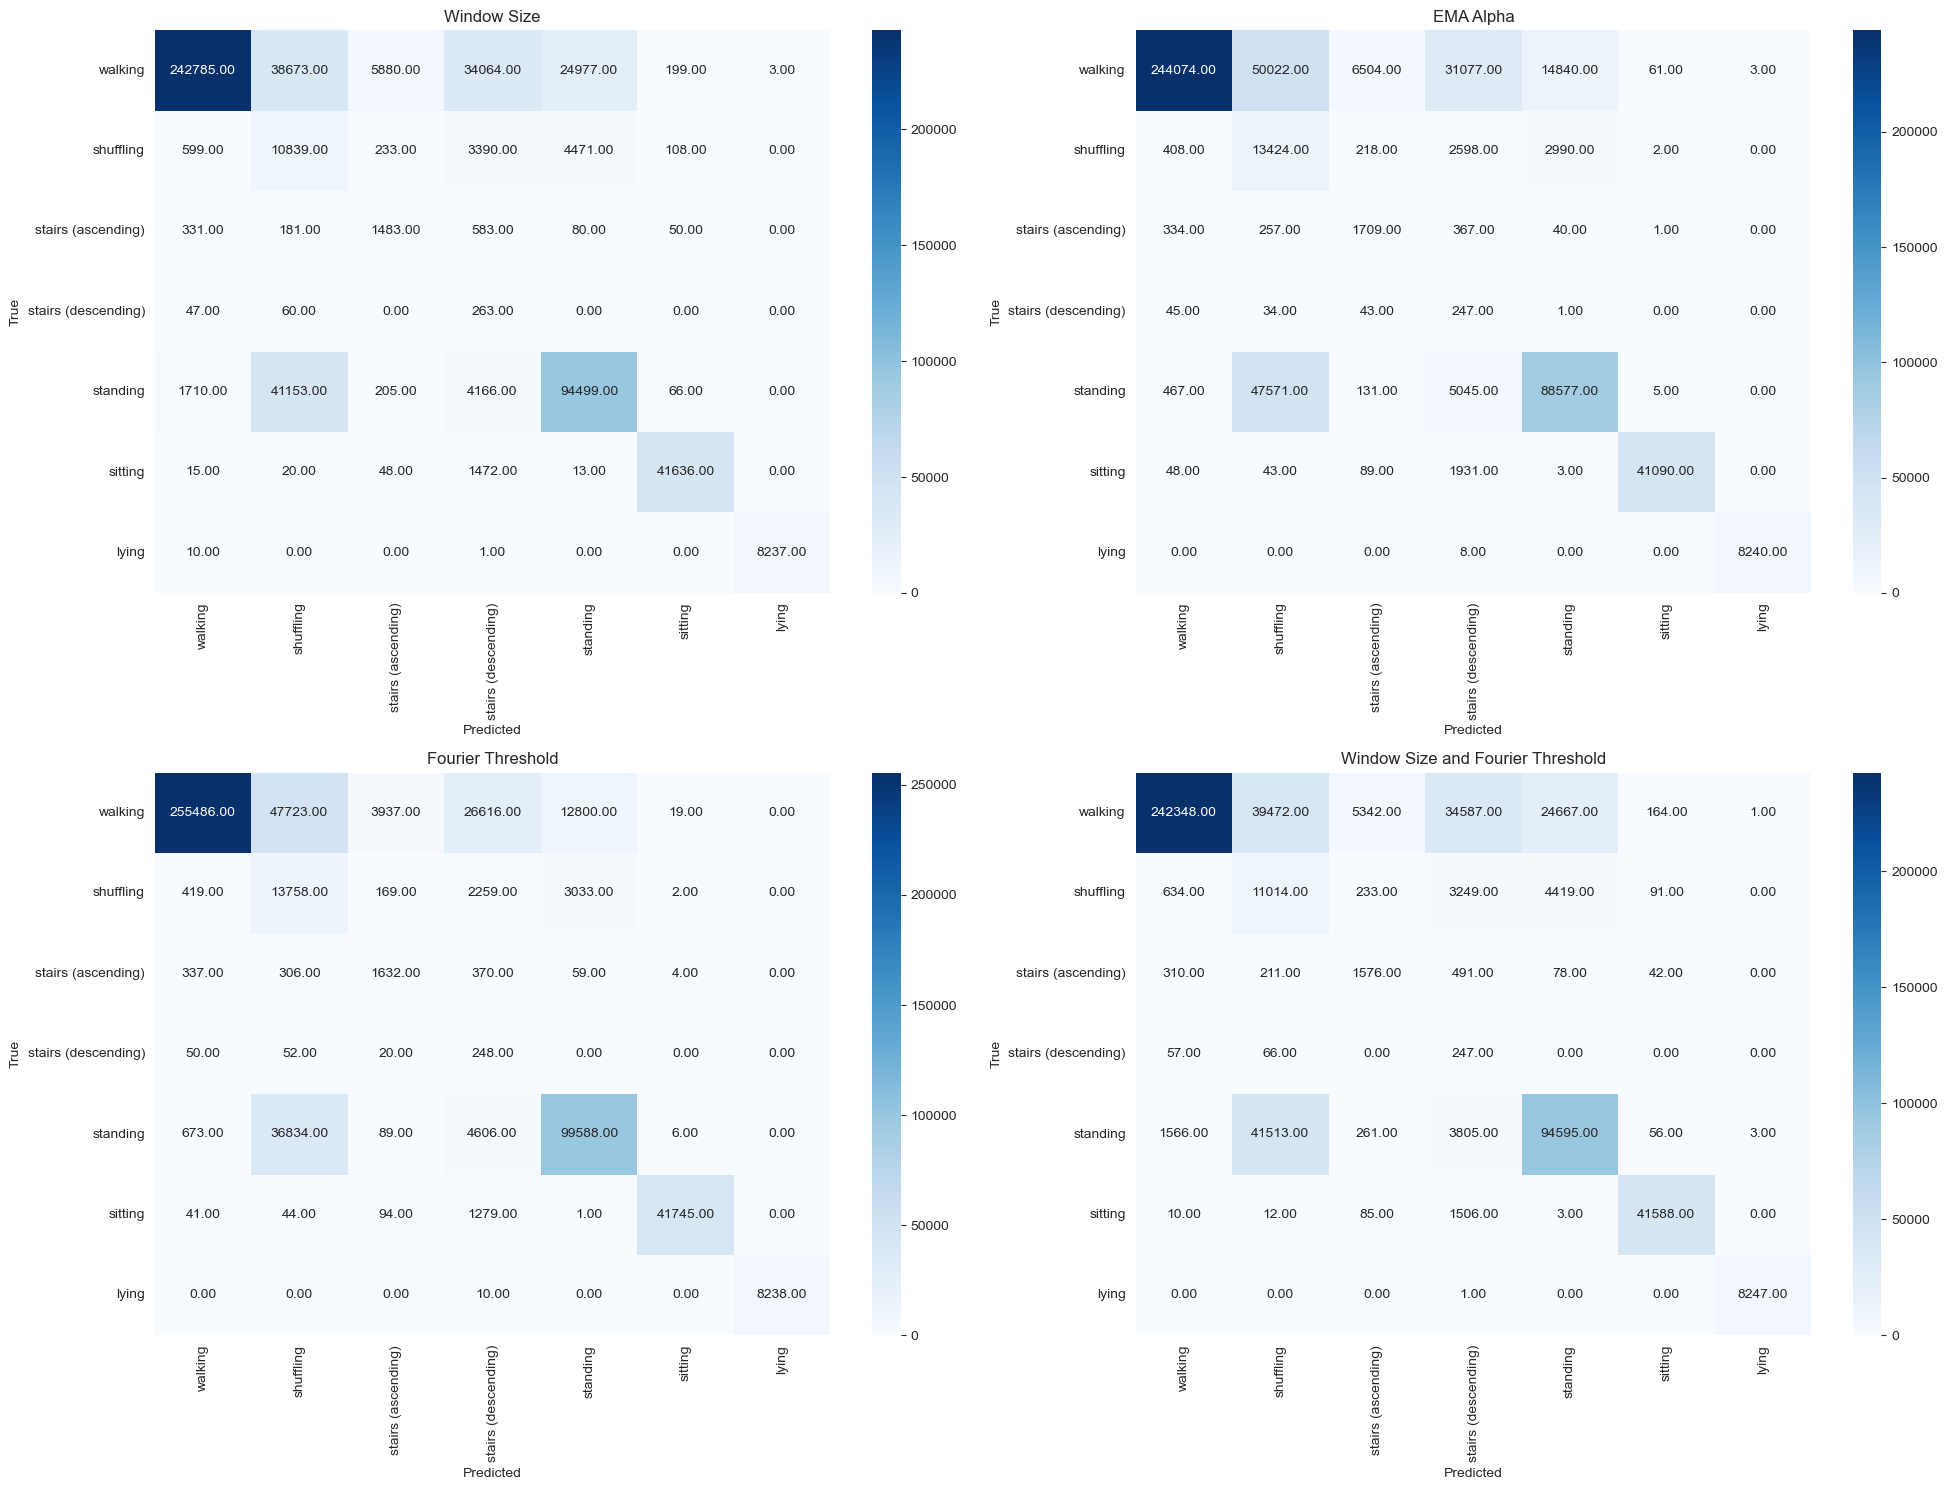

In [34]:
# Let's plot the confusion matrices for each model to see if there are any differences in the classification performance
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['walking', 'shuffling', 'stairs (ascending)', 'stairs (descending)', 'standing', 'sitting', 'lying']

plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
plt.title('Window Size')
sns.heatmap(confusion_matrix(y_test_decoded_window, y_pred_decoded_window), annot=True, fmt='.2f', xticklabels=labels,
            yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 2)
plt.title('EMA Alpha')
sns.heatmap(confusion_matrix(y_test_decoded_ema, y_pred_decoded_ema), annot=True, fmt='.2f', xticklabels=labels,
            yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 3)
plt.title('Fourier Threshold')
sns.heatmap(confusion_matrix(y_test_decoded_fourier, y_pred_decoded_fourier), annot=True, fmt='.2f', xticklabels=labels,
            yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 4)
plt.title('Window Size and Fourier Threshold')
sns.heatmap(confusion_matrix(y_test_decoded_window_fourier, y_pred_decoded_window_fourier), annot=True, fmt='.2f',
            xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

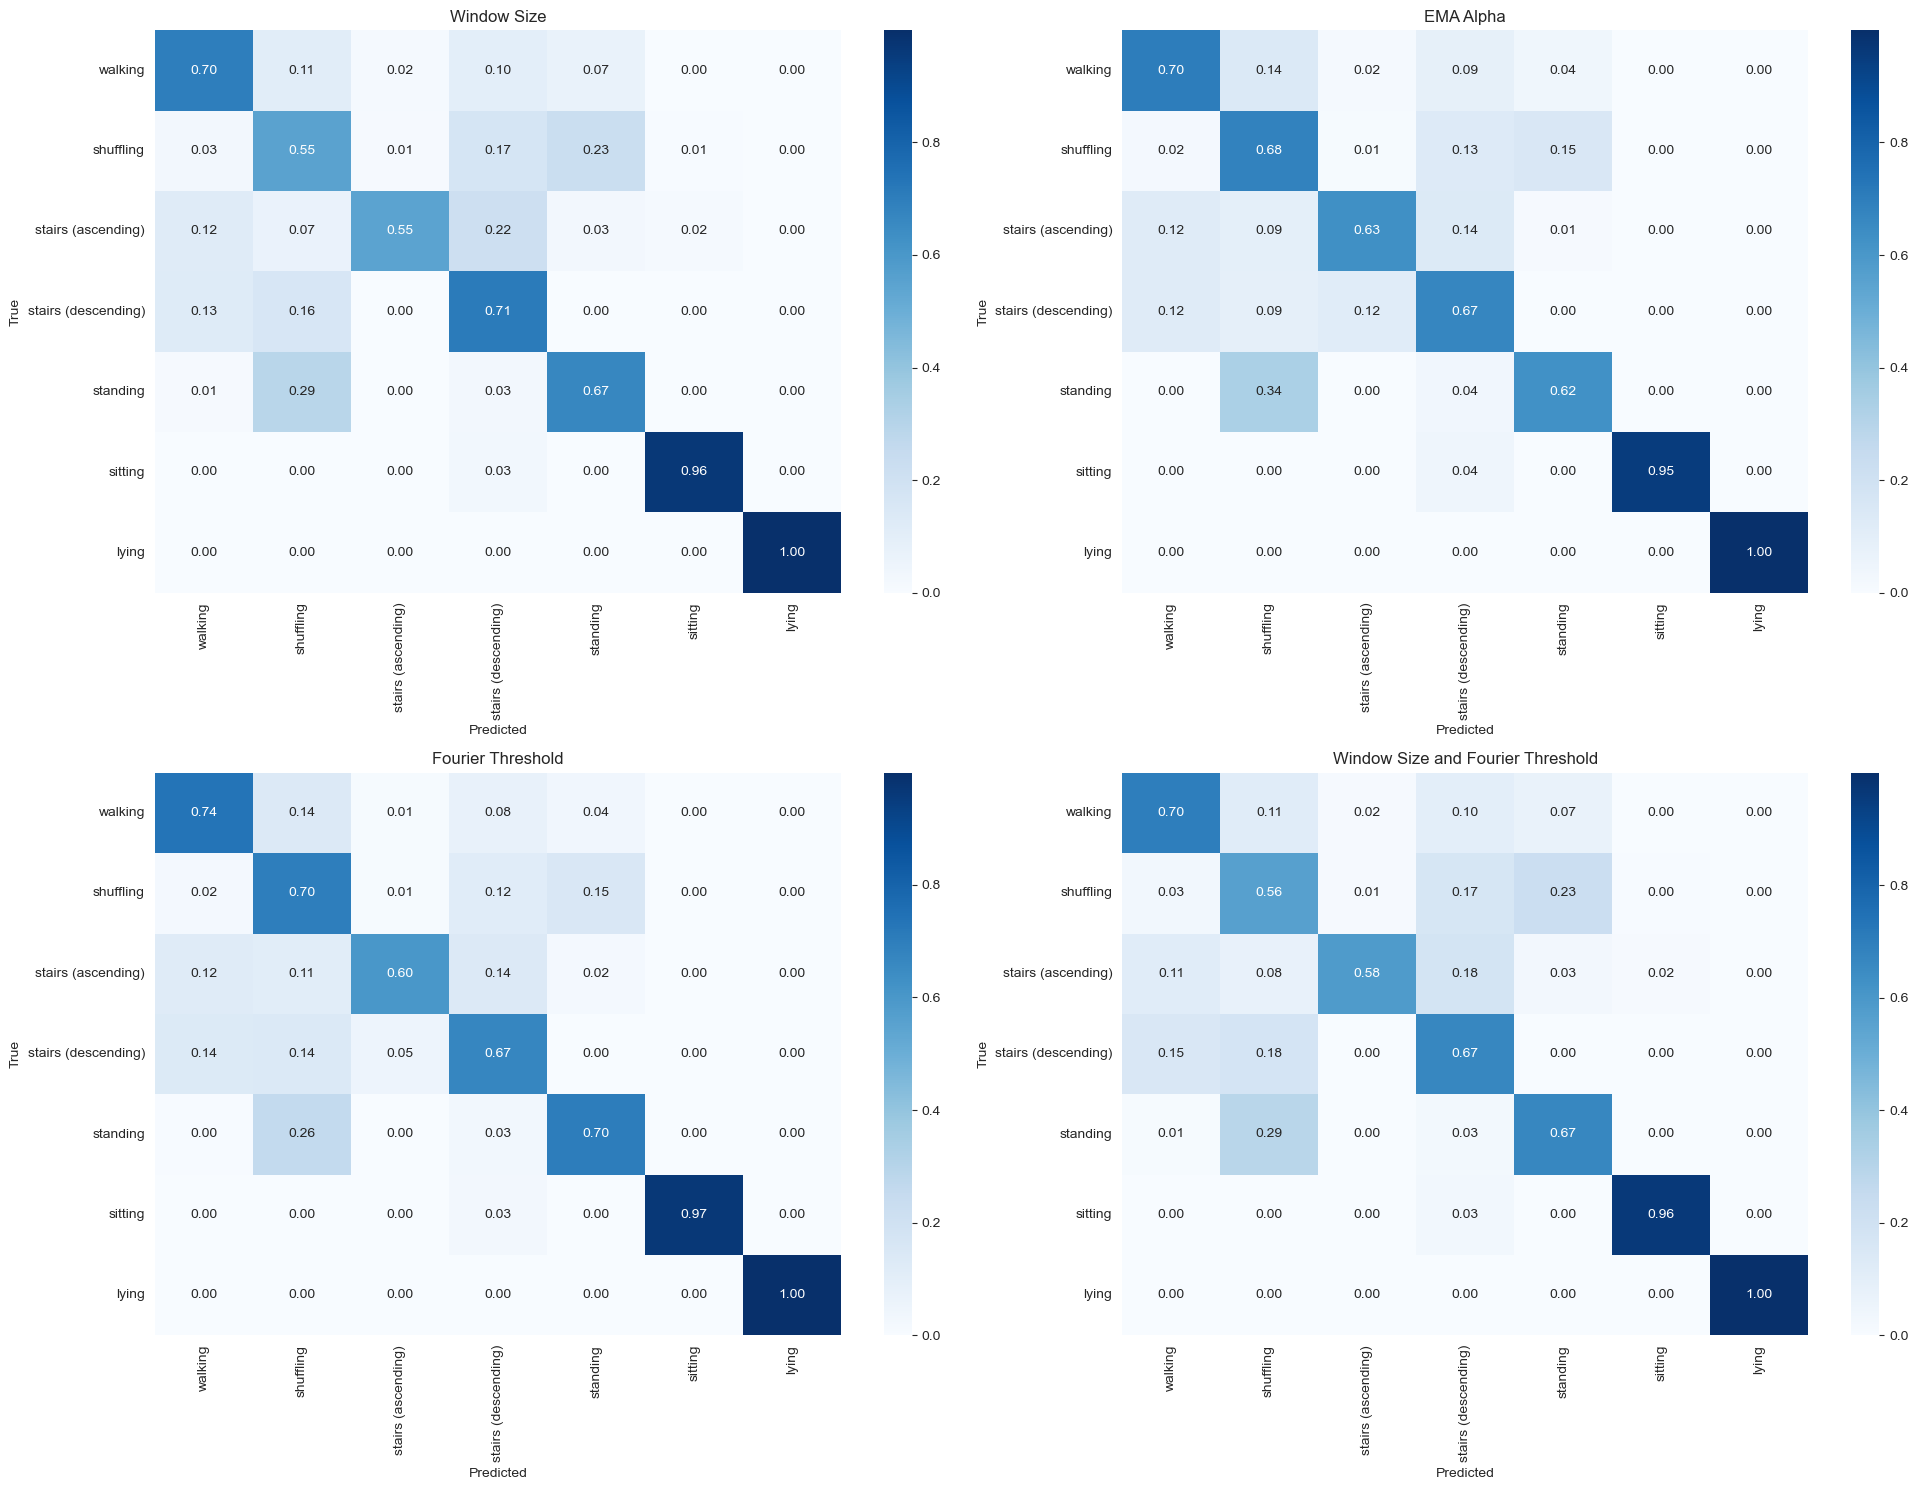

In [35]:
# Let's do the same but with a normalised confusion matrix as there is a large class imbalance
plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
plt.title('Window Size')
sns.heatmap(confusion_matrix(y_test_decoded_window, y_pred_decoded_window, normalize='true'), annot=True, fmt='.2f',
            xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 2)
plt.title('EMA Alpha')
sns.heatmap(confusion_matrix(y_test_decoded_ema, y_pred_decoded_ema, normalize='true'), annot=True, fmt='.2f',
            xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 3)
plt.title('Fourier Threshold')
sns.heatmap(confusion_matrix(y_test_decoded_fourier, y_pred_decoded_fourier, normalize='true'), annot=True, fmt='.2f',
            xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 4)
plt.title('Window Size and Fourier Threshold')
sns.heatmap(confusion_matrix(y_test_decoded_window_fourier, y_pred_decoded_window_fourier, normalize='true'),
            annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [36]:
# Let's also print the classification report for each model
from sklearn.metrics import classification_report

print("Window Size")
print(classification_report(y_test_decoded_window, y_pred_decoded_window))
print("-" * 80)

print("EMA Alpha")
print(classification_report(y_test_decoded_ema, y_pred_decoded_ema))
print("-" * 80)

print("Fourier Threshold")
print(classification_report(y_test_decoded_fourier, y_pred_decoded_fourier))
print("-" * 80)

print("Window Size and Fourier Threshold")
print(classification_report(y_test_decoded_window_fourier, y_pred_decoded_window_fourier))

Window Size
              precision    recall  f1-score   support

           1       0.99      0.70      0.82    346581
           3       0.12      0.55      0.20     19640
           4       0.19      0.55      0.28      2708
           5       0.01      0.71      0.01       370
           6       0.76      0.67      0.71    141799
           7       0.99      0.96      0.98     43204
           8       1.00      1.00      1.00      8248

    accuracy                           0.71    562550
   macro avg       0.58      0.73      0.57    562550
weighted avg       0.90      0.71      0.78    562550

--------------------------------------------------------------------------------
EMA Alpha
              precision    recall  f1-score   support

           1       0.99      0.70      0.82    346581
           3       0.12      0.68      0.20     19640
           4       0.20      0.63      0.30      2708
           5       0.01      0.67      0.01       370
           6       0.83      

In [37]:
# From our basicESN testing, we know that there are some ranges of suboptimal hyperparameters, so these can be excluded from the search space to save time

# This is constant as this performed the best, whilst still computing in a reasonable time
n_neurons = 500

density_range = [0.5, 0.75, 0.8, 0.9, 0.95, 0.99]
leakage_range = [0.6, 0.75, 0.8, 0.9, 0.95, 0.99]
spectral_radius_range = [0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
gamma_range = [0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
sparsity_range = [0.1, 0.3, 0.5, 0.7, 0.9]

input_weight_type = 'uniform'

# When working on the ridge baseline, 
window_sizes = [10, 50, 100]
alphas = [0.01, 0.1, 0.5, 0.9, 0.99]
thresholds = [1e-1, 1e-2, 1e-3, 1e-4]

In [40]:
# The fourier smoothing seems to be performing the best at present, so let's try some hyperparameter tuning with this method as a preprocessing step
run_fourier_hyperparameter_tuning = False

In [38]:

# Due to the size of the search space, we try using hyperopt to find the best hyperparameters

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK


def fourier_objective(params):
    input_weights = generate_input_weights(n_neurons, X_train_scaled.shape[1], params['density'], input_weight_type,
                                           seed=42)

    basic_esn = BasicESN(n_neurons=n_neurons, leakage_rate=params['leakage'], spectral_radius=params['spectral_radius'],
                         gamma=params['gamma'], sparsity=params['sparsity'], W_in=input_weights,
                         class_weights=data_preparation.get_class_weights(), seed=42, is_optimising=True)

    x_train_fourier = data_preprocessor.fourier_smoothing(X_train_scaled, params['threshold'])
    x_val_fourier = data_preprocessor.fourier_smoothing(X_val_scaled, params['threshold'])
    x_test_fourier = data_preprocessor.fourier_smoothing(X_test_scaled, params['threshold'])

    basic_esn.fit(x_train_fourier, y_train_encoded, x_val=x_val_fourier, y_val=y_val_encoded)

    y_pred = basic_esn.forward(x_test_fourier)

    # Before we can score the model, we need to decode the one-hot encoded labels
    y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)
    y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)

    # Calculate the NMRSE score
    nrmse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (y_test_decoded.max() - y_test_decoded.min())

    return {'loss': nrmse, 'status': STATUS_OK}

In [39]:
n_iterations = 10

if run_fourier_hyperparameter_tuning:
    space = {
        'density': hp.choice('density', density_range),
        'leakage': hp.choice('leakage', leakage_range),
        'spectral_radius': hp.choice('spectral_radius', spectral_radius_range),
        'gamma': hp.choice('gamma', gamma_range),
        'sparsity': hp.choice('sparsity', sparsity_range),
        'threshold': hp.choice('threshold', thresholds)
    }

    trials = Trials()

    best = fmin(fourier_objective, space, algo=tpe.suggest, max_evals=n_iterations, trials=trials)

    print(best)

else:
    best = {'density': 3, 'gamma': 4, 'leakage': 2, 'sparsity': 3, 'spectral_radius': 5, 'threshold': 0}

[]                                                    
Is CUDA available: True                               
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.8, gamma: 0.8, n_neurons: 500, sparsity: 0.9
Fourier data shape: (1357646, 6)                      
Fourier data shape: (339404, 6)                       
Fourier data shape: (562547, 6)                       
  0%|          | 0/10 [00:05<?, ?trial/s, best loss=?]

  0%|          | 0/1357646 [00:00<?, ?it/s]

  1%|          | 10000/1357646 [00:00<00:31, 42340.75it/s]

  1%|1         | 20000/1357646 [00:03<04:09, 5353.19it/s] 

  2%|2         | 30000/1357646 [00:06<05:11, 4255.32it/s]

  3%|2         | 40000/1357646 [00:09<05:43, 3838.35it/s]

  4%|3         | 50000/1357646 [00:12<05:58, 3649.83it/s]

  4%|4         | 60000/1357646 [00:15<06:04, 3558.46it/s]

  5%|5         | 70000/1357646 [00:18<06:08, 3494.09it/s]

  6%|5         | 80000/1357646 [00:21<06:10, 3444.27it/s]

  7%|6         | 90000/1357646 [00:24<06:12, 3399.88it/s]

  7%|7         | 100000/1357646 [00:27<06:13, 3366.11it/s]

  8%|8         | 110000/1357646 [00:30<06:13, 3340.70it/s]

  9%|8         | 120000/1357646 [00:33<06:08, 3359.09it/s]

 10%|9         | 130000/1357646 [00:36<06:04, 3369.46it/s]

 10%|#         | 140000/1357646 [00:39<06:01, 3364.83it/s]

 11%|#1        | 150000/1357646 [00:42<05:59, 3361.66it/s]

 12%|#1        | 160000/1357646 [00:44<05:55, 3368.10it/s]

 1

Shape of previous_states: (1357646, 500)              
Reservoir state computed, fitting readout layer...    
Validation data provided, scoring readout layer based on validation data...
  0%|          | 0/10 [06:50<?, ?trial/s, best loss=?]

  0%|          | 0/339404 [00:00<?, ?it/s]

  6%|5         | 20000/339404 [00:03<00:49, 6450.93it/s]

  9%|8         | 30000/339404 [00:06<01:06, 4676.78it/s]

 12%|#1        | 40000/339404 [00:08<01:12, 4124.68it/s]

 15%|#4        | 50000/339404 [00:11<01:15, 3855.71it/s]

 18%|#7        | 60000/339404 [00:14<01:16, 3657.03it/s]

 21%|##        | 70000/339404 [00:17<01:15, 3570.13it/s]

 24%|##3       | 80000/339404 [00:20<01:13, 3515.46it/s]

 27%|##6       | 90000/339404 [00:23<01:11, 3504.92it/s]

 29%|##9       | 100000/339404 [00:26<01:09, 3466.06it/s]

 32%|###2      | 110000/339404 [00:29<01:06, 3430.43it/s]

 35%|###5      | 120000/339404 [00:32<01:04, 3392.32it/s]

 38%|###8      | 130000/339404 [00:35<01:02, 3375.62it/s]

 41%|####1     | 140000/339404 [00:38<00:59, 3362.48it/s]

 44%|####4     | 150000/339404 [00:41<00:56, 3356.74it/s]

 47%|####7     | 160000/339404 [00:44<00:54, 3292.38it/s]

 50%|#####     | 170000/339404 [00:47<00:51, 3317.82it/s]

 53%|#####3    | 180

Shape of previous_states: (339404, 500)               
Alpha: 1e-05, Score: 0.29389415785282175              
Alpha: 5.994842503189409e-05, Score: 0.3015436569909958
Alpha: 0.00035938136638046257, Score: 0.30461523561439546
Alpha: 0.0021544346900318843, Score: 0.2978790437078575
Alpha: 0.01291549665014884, Score: 0.2858933393845046 
Alpha: 0.0774263682681127, Score: 0.2688568092693787  
Alpha: 0.4641588833612782, Score: 0.2382070980040155  
Alpha: 2.782559402207126, Score: 0.18739294130457118  
Alpha: 16.68100537200059, Score: 0.13274984195017872  
Alpha: 100.0, Score: 0.10116707065993362              
Best alpha: 0.00035938136638046257                    
Readout layer fitted.                                 
  0%|          | 0/10 [11:42<?, ?trial/s, best loss=?]

  0%|          | 0/562547 [00:00<?, ?it/s]

  2%|1         | 10000/562547 [00:00<00:09, 55670.64it/s]

  4%|3         | 20000/562547 [00:03<01:39, 5466.92it/s] 

  5%|5         | 30000/562547 [00:06<02:04, 4283.84it/s]

  7%|7         | 40000/562547 [00:09<02:14, 3871.65it/s]

  9%|8         | 50000/562547 [00:12<02:20, 3643.75it/s]

 11%|#         | 60000/562547 [00:15<02:21, 3546.61it/s]

 12%|#2        | 70000/562547 [00:18<02:21, 3488.24it/s]

 14%|#4        | 80000/562547 [00:20<02:19, 3456.53it/s]

 16%|#5        | 90000/562547 [00:23<02:17, 3433.35it/s]

 18%|#7        | 100000/562547 [00:26<02:15, 3411.08it/s]

 20%|#9        | 110000/562547 [00:29<02:13, 3382.66it/s]

 21%|##1       | 120000/562547 [00:32<02:11, 3371.80it/s]

 23%|##3       | 130000/562547 [00:35<02:08, 3373.88it/s]

 25%|##4       | 140000/562547 [00:38<02:05, 3367.84it/s]

 27%|##6       | 150000/562547 [00:41<02:02, 3372.38it/s]

 28%|##8       | 160000/562547 [00:44<01:59, 3368.74it/s]

 30%|###       | 17

Shape of previous_states: (562547, 500)               
[]                                                                                  
Is CUDA available: True                                                             
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.99, gamma: 0.95, n_neurons: 500, sparsity: 0.9
Fourier data shape: (1357646, 6)                                                    
Fourier data shape: (339404, 6)                                                     
Fourier data shape: (562547, 6)                                                     
 10%|█         | 1/10 [14:34<2:10:25, 869.52s/trial, best loss: 0.24075704553653435]

  0%|          | 0/1357646 [00:00<?, ?it/s]

  1%|          | 10000/1357646 [00:00<00:41, 32643.44it/s]

  1%|1         | 20000/1357646 [00:03<04:11, 5312.48it/s] 

  2%|2         | 30000/1357646 [00:06<05:16, 4195.60it/s]

  3%|2         | 40000/1357646 [00:09<05:48, 3777.11it/s]

  4%|3         | 50000/1357646 [00:12<06:00, 3628.55it/s]

  4%|4         | 60000/1357646 [00:15<06:03, 3567.93it/s]

  5%|5         | 70000/1357646 [00:18<06:05, 3525.74it/s]

  6%|5         | 80000/1357646 [00:21<06:08, 3466.33it/s]

  7%|6         | 90000/1357646 [00:24<06:08, 3439.54it/s]

  7%|7         | 100000/1357646 [00:26<06:06, 3434.59it/s]

  8%|8         | 110000/1357646 [00:29<06:04, 3426.52it/s]

  9%|8         | 120000/1357646 [00:32<06:04, 3399.27it/s]

 10%|9         | 130000/1357646 [00:35<06:06, 3348.46it/s]

 10%|#         | 140000/1357646 [00:38<06:01, 3367.87it/s]

 11%|#1        | 150000/1357646 [00:41<05:58, 3372.76it/s]

 12%|#1        | 160000/1357646 [00:44<05:55, 3370.80it/s]

 1

Shape of previous_states: (1357646, 500)                                            
Reservoir state computed, fitting readout layer...                                  
Validation data provided, scoring readout layer based on validation data...         
 10%|█         | 1/10 [21:20<2:10:25, 869.52s/trial, best loss: 0.24075704553653435]

  0%|          | 0/339404 [00:00<?, ?it/s]

  6%|5         | 20000/339404 [00:03<00:48, 6587.60it/s]

  9%|8         | 30000/339404 [00:05<01:04, 4780.08it/s]

 12%|#1        | 40000/339404 [00:08<01:11, 4158.49it/s]

 15%|#4        | 50000/339404 [00:11<01:15, 3857.14it/s]

 18%|#7        | 60000/339404 [00:14<01:17, 3604.07it/s]

 21%|##        | 70000/339404 [00:17<01:16, 3533.61it/s]

 24%|##3       | 80000/339404 [00:20<01:14, 3478.43it/s]

 27%|##6       | 90000/339404 [00:23<01:12, 3449.91it/s]

 29%|##9       | 100000/339404 [00:26<01:09, 3420.11it/s]

 32%|###2      | 110000/339404 [00:29<01:07, 3410.81it/s]

 35%|###5      | 120000/339404 [00:32<01:05, 3369.19it/s]

 38%|###8      | 130000/339404 [00:35<01:02, 3356.86it/s]

 41%|####1     | 140000/339404 [00:38<00:59, 3356.89it/s]

 44%|####4     | 150000/339404 [00:41<00:56, 3361.05it/s]

 47%|####7     | 160000/339404 [00:44<00:53, 3341.44it/s]

 50%|#####     | 170000/339404 [00:47<00:51, 3301.94it/s]

 53%|#####3    | 180

Shape of previous_states: (339404, 500)                                             
Alpha: 1e-05, Score: -0.01048962607095627                                           
Alpha: 5.994842503189409e-05, Score: 0.1859639768558445                             
Alpha: 0.00035938136638046257, Score: 0.21403165616897388                           
Alpha: 0.0021544346900318843, Score: 0.21356322539273082                            
Alpha: 0.01291549665014884, Score: 0.19822096647775453                              
Alpha: 0.0774263682681127, Score: 0.18173399868045312                               
Alpha: 0.4641588833612782, Score: 0.16654113368453105                               
 10%|█         | 1/10 [25:37<2:10:25, 869.52s/trial, best loss: 0.24075704553653435]

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.83009e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.782559402207126, Score: 0.14754153454841695                                
Alpha: 16.68100537200059, Score: 0.12187339658278738                                
Alpha: 100.0, Score: 0.10343412733747558                                            
Best alpha: 0.00035938136638046257                                                  
Readout layer fitted.                                                               
 10%|█         | 1/10 [26:10<2:10:25, 869.52s/trial, best loss: 0.24075704553653435]

  0%|          | 0/562547 [00:00<?, ?it/s]

  2%|1         | 10000/562547 [00:00<00:09, 56932.83it/s]

  4%|3         | 20000/562547 [00:03<01:42, 5293.47it/s] 

  5%|5         | 30000/562547 [00:06<02:06, 4204.30it/s]

  7%|7         | 40000/562547 [00:09<02:17, 3787.36it/s]

  9%|8         | 50000/562547 [00:12<02:24, 3559.18it/s]

 11%|#         | 60000/562547 [00:15<02:25, 3444.02it/s]

 12%|#2        | 70000/562547 [00:18<02:25, 3382.21it/s]

 14%|#4        | 80000/562547 [00:21<02:24, 3347.12it/s]

 16%|#5        | 90000/562547 [00:24<02:21, 3348.19it/s]

 18%|#7        | 100000/562547 [00:27<02:18, 3338.05it/s]

 20%|#9        | 110000/562547 [00:30<02:15, 3343.97it/s]

 21%|##1       | 120000/562547 [00:33<02:11, 3359.69it/s]

 23%|##3       | 130000/562547 [00:36<02:08, 3354.67it/s]

 25%|##4       | 140000/562547 [00:39<02:05, 3354.25it/s]

 27%|##6       | 150000/562547 [00:42<02:02, 3365.78it/s]

 28%|##8       | 160000/562547 [00:45<01:59, 3355.68it/s]

 30%|###       | 17

Shape of previous_states: (562547, 500)                                             
[]                                                                                  
Is CUDA available: True                                                             
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.9, gamma: 0.6, n_neurons: 500, sparsity: 0.1
Fourier data shape: (1357646, 6)                                                    
Fourier data shape: (339404, 6)                                                     
Fourier data shape: (562547, 6)                                                     
 20%|██        | 2/10 [29:05<1:56:03, 870.47s/trial, best loss: 0.24075704553653435]

  0%|          | 0/1357646 [00:00<?, ?it/s]

  1%|          | 10000/1357646 [00:00<00:33, 40388.64it/s]

  1%|1         | 20000/1357646 [00:03<04:06, 5417.13it/s] 

  2%|2         | 30000/1357646 [00:06<05:14, 4219.22it/s]

  3%|2         | 40000/1357646 [00:09<05:43, 3835.83it/s]

  4%|3         | 50000/1357646 [00:12<05:56, 3670.17it/s]

  4%|4         | 60000/1357646 [00:15<06:01, 3593.88it/s]

  5%|5         | 70000/1357646 [00:17<06:05, 3522.30it/s]

  6%|5         | 80000/1357646 [00:20<06:08, 3465.91it/s]

  7%|6         | 90000/1357646 [00:23<06:07, 3450.08it/s]

  7%|7         | 100000/1357646 [00:26<06:08, 3410.64it/s]

  8%|8         | 110000/1357646 [00:30<06:13, 3338.15it/s]

  9%|8         | 120000/1357646 [00:32<06:09, 3350.78it/s]

 10%|9         | 130000/1357646 [00:35<06:06, 3351.80it/s]

 10%|#         | 140000/1357646 [00:38<06:01, 3369.52it/s]

 11%|#1        | 150000/1357646 [00:41<05:58, 3366.93it/s]

 12%|#1        | 160000/1357646 [00:44<05:54, 3380.86it/s]

 1

Shape of previous_states: (1357646, 500)                                            
Reservoir state computed, fitting readout layer...                                  
Validation data provided, scoring readout layer based on validation data...         
 20%|██        | 2/10 [35:48<1:56:03, 870.47s/trial, best loss: 0.24075704553653435]

  0%|          | 0/339404 [00:00<?, ?it/s]

  6%|5         | 20000/339404 [00:02<00:47, 6681.01it/s]

  9%|8         | 30000/339404 [00:05<01:04, 4776.75it/s]

 12%|#1        | 40000/339404 [00:08<01:12, 4133.60it/s]

 15%|#4        | 50000/339404 [00:11<01:14, 3873.35it/s]

 18%|#7        | 60000/339404 [00:14<01:14, 3739.72it/s]

 21%|##        | 70000/339404 [00:17<01:13, 3648.59it/s]

 24%|##3       | 80000/339404 [00:20<01:12, 3569.79it/s]

 27%|##6       | 90000/339404 [00:23<01:10, 3519.87it/s]

 29%|##9       | 100000/339404 [00:26<01:08, 3484.15it/s]

 32%|###2      | 110000/339404 [00:29<01:06, 3453.47it/s]

 35%|###5      | 120000/339404 [00:32<01:03, 3452.84it/s]

 38%|###8      | 130000/339404 [00:35<01:01, 3421.34it/s]

 41%|####1     | 140000/339404 [00:38<00:58, 3433.45it/s]

 44%|####4     | 150000/339404 [00:40<00:54, 3456.41it/s]

 47%|####7     | 160000/339404 [00:43<00:51, 3450.73it/s]

 50%|#####     | 170000/339404 [00:46<00:49, 3430.91it/s]

 53%|#####3    | 180

Shape of previous_states: (339404, 500)                                             
Alpha: 1e-05, Score: -0.2726400414362418                                            
Alpha: 5.994842503189409e-05, Score: -0.06987773792219287                           
Alpha: 0.00035938136638046257, Score: 0.14712245122426304                           
Alpha: 0.0021544346900318843, Score: 0.21067854714040127                            
Alpha: 0.01291549665014884, Score: 0.2500435267339939                               
Alpha: 0.0774263682681127, Score: 0.24808019044551438                               
 20%|██        | 2/10 [39:44<1:56:03, 870.47s/trial, best loss: 0.24075704553653435]

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.86329e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 0.4641588833612782, Score: 0.2197225446109275                                
Alpha: 2.782559402207126, Score: 0.16433004075804064                                
Alpha: 16.68100537200059, Score: 0.1177078732139455                                 
Alpha: 100.0, Score: 0.09441006796533677                                            
Best alpha: 0.01291549665014884                                                     
Readout layer fitted.                                                               
 20%|██        | 2/10 [40:23<1:56:03, 870.47s/trial, best loss: 0.24075704553653435]

  0%|          | 0/562547 [00:00<?, ?it/s]

  2%|1         | 10000/562547 [00:00<00:09, 56615.98it/s]

  4%|3         | 20000/562547 [00:03<01:39, 5444.78it/s] 

  5%|5         | 30000/562547 [00:06<02:08, 4144.21it/s]

  7%|7         | 40000/562547 [00:09<02:17, 3794.70it/s]

  9%|8         | 50000/562547 [00:12<02:20, 3648.67it/s]

 11%|#         | 60000/562547 [00:15<02:20, 3571.04it/s]

 12%|#2        | 70000/562547 [00:18<02:19, 3526.39it/s]

 14%|#4        | 80000/562547 [00:20<02:18, 3491.11it/s]

 16%|#5        | 90000/562547 [00:23<02:16, 3471.57it/s]

 18%|#7        | 100000/562547 [00:26<02:13, 3457.64it/s]

 20%|#9        | 110000/562547 [00:29<02:11, 3451.50it/s]

 21%|##1       | 120000/562547 [00:32<02:08, 3434.38it/s]

 23%|##3       | 130000/562547 [00:35<02:05, 3441.35it/s]

 25%|##4       | 140000/562547 [00:38<02:02, 3439.74it/s]

 27%|##6       | 150000/562547 [00:41<01:59, 3440.00it/s]

 28%|##8       | 160000/562547 [00:44<01:57, 3422.85it/s]

 30%|###       | 17

Shape of previous_states: (562547, 500)                                             
[]                                                                                  
Is CUDA available: True                                                             
BasicESN initialised with leakage_rate: 0.6, spectral_radius: 0.6, gamma: 0.6, n_neurons: 500, sparsity: 0.9
Fourier data shape: (1357646, 6)                                                    
Fourier data shape: (339404, 6)                                                     
Fourier data shape: (562547, 6)                                                     
 30%|███       | 3/10 [43:16<1:40:30, 861.57s/trial, best loss: 0.24075704553653435]

  0%|          | 0/1357646 [00:00<?, ?it/s]

  1%|          | 10000/1357646 [00:00<00:49, 27081.22it/s]

  1%|1         | 20000/1357646 [00:03<04:11, 5327.38it/s] 

  2%|2         | 30000/1357646 [00:06<05:12, 4253.27it/s]

  3%|2         | 40000/1357646 [00:09<05:39, 3886.46it/s]

  4%|3         | 50000/1357646 [00:12<05:53, 3696.62it/s]

  4%|4         | 60000/1357646 [00:14<06:00, 3604.35it/s]

  5%|5         | 70000/1357646 [00:17<06:03, 3540.01it/s]

  6%|5         | 80000/1357646 [00:20<06:04, 3505.69it/s]

  7%|6         | 90000/1357646 [00:23<06:02, 3499.38it/s]

  7%|7         | 100000/1357646 [00:26<05:59, 3494.67it/s]

  8%|8         | 110000/1357646 [00:29<06:03, 3436.70it/s]

  9%|8         | 120000/1357646 [00:32<06:05, 3384.75it/s]

 10%|9         | 130000/1357646 [00:35<06:04, 3372.62it/s]

 10%|#         | 140000/1357646 [00:38<06:00, 3380.86it/s]

 11%|#1        | 150000/1357646 [00:41<06:01, 3342.44it/s]

 12%|#1        | 160000/1357646 [00:44<05:59, 3329.63it/s]

 1

Shape of previous_states: (1357646, 500)                                            
Reservoir state computed, fitting readout layer...                                  
Validation data provided, scoring readout layer based on validation data...         
 30%|███       | 3/10 [50:02<1:40:30, 861.57s/trial, best loss: 0.24075704553653435]

  0%|          | 0/339404 [00:00<?, ?it/s]

  6%|5         | 20000/339404 [00:02<00:47, 6670.31it/s]

  9%|8         | 30000/339404 [00:05<01:05, 4722.94it/s]

 12%|#1        | 40000/339404 [00:08<01:12, 4139.46it/s]

 15%|#4        | 50000/339404 [00:11<01:15, 3853.55it/s]

 18%|#7        | 60000/339404 [00:14<01:16, 3670.89it/s]

 21%|##        | 70000/339404 [00:17<01:16, 3499.50it/s]

 24%|##3       | 80000/339404 [00:20<01:15, 3449.23it/s]

 27%|##6       | 90000/339404 [00:23<01:12, 3416.76it/s]

 29%|##9       | 100000/339404 [00:26<01:09, 3435.90it/s]

 32%|###2      | 110000/339404 [00:29<01:06, 3424.13it/s]

 35%|###5      | 120000/339404 [00:32<01:04, 3419.90it/s]

 38%|###8      | 130000/339404 [00:35<01:01, 3430.17it/s]

 41%|####1     | 140000/339404 [00:38<00:57, 3438.99it/s]

 44%|####4     | 150000/339404 [00:41<00:55, 3430.28it/s]

 47%|####7     | 160000/339404 [00:44<00:52, 3409.75it/s]

 50%|#####     | 170000/339404 [00:47<00:49, 3405.46it/s]

 53%|#####3    | 180

Shape of previous_states: (339404, 500)                                             
Alpha: 1e-05, Score: 0.27530549027187173                                            
Alpha: 5.994842503189409e-05, Score: 0.27307914592885524                            
Alpha: 0.00035938136638046257, Score: 0.2647438626609521                            
Alpha: 0.0021544346900318843, Score: 0.2537181223225085                             
Alpha: 0.01291549665014884, Score: 0.23939697385035302                              
Alpha: 0.0774263682681127, Score: 0.21355871624631886                               
 30%|███       | 3/10 [53:57<1:40:30, 861.57s/trial, best loss: 0.24075704553653435]

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.1024e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 0.4641588833612782, Score: 0.17091203326880983                               
Alpha: 2.782559402207126, Score: 0.11875836372111255                                
Alpha: 16.68100537200059, Score: 0.08945147814530952                                
Alpha: 100.0, Score: 0.06990918265194745                                            
Best alpha: 1e-05                                                                   
Readout layer fitted.                                                               
 30%|███       | 3/10 [54:35<1:40:30, 861.57s/trial, best loss: 0.24075704553653435]

  0%|          | 0/562547 [00:00<?, ?it/s]

  2%|1         | 10000/562547 [00:00<00:09, 58576.72it/s]

  4%|3         | 20000/562547 [00:03<01:42, 5269.30it/s] 

  5%|5         | 30000/562547 [00:06<02:06, 4212.34it/s]

  7%|7         | 40000/562547 [00:09<02:15, 3867.64it/s]

  9%|8         | 50000/562547 [00:12<02:19, 3677.43it/s]

 11%|#         | 60000/562547 [00:15<02:20, 3571.28it/s]

 12%|#2        | 70000/562547 [00:18<02:21, 3480.88it/s]

 14%|#4        | 80000/562547 [00:21<02:19, 3456.62it/s]

 16%|#5        | 90000/562547 [00:23<02:16, 3469.15it/s]

 18%|#7        | 100000/562547 [00:26<02:14, 3441.92it/s]

 20%|#9        | 110000/562547 [00:29<02:11, 3447.02it/s]

 21%|##1       | 120000/562547 [00:32<02:08, 3451.64it/s]

 23%|##3       | 130000/562547 [00:35<02:06, 3422.23it/s]

 25%|##4       | 140000/562547 [00:38<02:03, 3415.34it/s]

 27%|##6       | 150000/562547 [00:41<02:01, 3391.92it/s]

 28%|##8       | 160000/562547 [00:44<02:00, 3333.24it/s]

 30%|###       | 17

Shape of previous_states: (562547, 500)                                             
[]                                                                                  
Is CUDA available: True                                                             
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.95, gamma: 0.95, n_neurons: 500, sparsity: 0.3
Fourier data shape: (1357646, 6)                                                    
Fourier data shape: (339404, 6)                                                     
Fourier data shape: (562547, 6)                                                     
 40%|████      | 4/10 [57:26<1:25:40, 856.73s/trial, best loss: 0.24075704553653435]

  0%|          | 0/1357646 [00:00<?, ?it/s]

  1%|          | 10000/1357646 [00:00<00:29, 45690.63it/s]

  1%|1         | 20000/1357646 [00:03<04:01, 5540.85it/s] 

  2%|2         | 30000/1357646 [00:06<05:10, 4272.91it/s]

  3%|2         | 40000/1357646 [00:08<05:36, 3914.67it/s]

  4%|3         | 50000/1357646 [00:11<05:48, 3754.06it/s]

  4%|4         | 60000/1357646 [00:14<05:52, 3686.41it/s]

  5%|5         | 70000/1357646 [00:17<05:59, 3585.24it/s]

  6%|5         | 80000/1357646 [00:20<05:59, 3554.75it/s]

  7%|6         | 90000/1357646 [00:23<05:59, 3528.48it/s]

  7%|7         | 100000/1357646 [00:26<06:01, 3482.46it/s]

  8%|8         | 110000/1357646 [00:29<06:06, 3401.25it/s]

  9%|8         | 120000/1357646 [00:32<06:02, 3412.32it/s]

 10%|9         | 130000/1357646 [00:35<06:00, 3404.17it/s]

 10%|#         | 140000/1357646 [00:38<05:54, 3435.48it/s]

 11%|#1        | 150000/1357646 [00:41<05:50, 3441.54it/s]

 12%|#1        | 160000/1357646 [00:43<05:47, 3445.31it/s]

 1

Shape of previous_states: (1357646, 500)                                            
Reservoir state computed, fitting readout layer...                                    
Validation data provided, scoring readout layer based on validation data...           
 40%|████      | 4/10 [1:04:02<1:25:40, 856.73s/trial, best loss: 0.24075704553653435]

  0%|          | 0/339404 [00:00<?, ?it/s]

  6%|5         | 20000/339404 [00:02<00:47, 6701.34it/s]

  9%|8         | 30000/339404 [00:05<01:04, 4770.70it/s]

 12%|#1        | 40000/339404 [00:08<01:11, 4164.08it/s]

 15%|#4        | 50000/339404 [00:11<01:14, 3876.28it/s]

 18%|#7        | 60000/339404 [00:14<01:15, 3680.93it/s]

 21%|##        | 70000/339404 [00:18<01:18, 3441.40it/s]

 24%|##3       | 80000/339404 [00:20<01:15, 3444.97it/s]

 27%|##6       | 90000/339404 [00:23<01:12, 3430.99it/s]

 29%|##9       | 100000/339404 [00:26<01:09, 3422.19it/s]

 32%|###2      | 110000/339404 [00:30<01:15, 3030.14it/s]

 35%|###5      | 120000/339404 [00:34<01:15, 2908.07it/s]

 38%|###8      | 130000/339404 [00:37<01:09, 3011.16it/s]

 41%|####1     | 140000/339404 [00:40<01:03, 3124.19it/s]

 44%|####4     | 150000/339404 [00:43<00:58, 3212.13it/s]

 47%|####7     | 160000/339404 [00:46<00:54, 3279.45it/s]

 50%|#####     | 170000/339404 [00:49<00:50, 3325.98it/s]

 53%|#####3    | 180

Shape of previous_states: (339404, 500)                                               
Alpha: 1e-05, Score: -2.1396212996386237                                              
Alpha: 5.994842503189409e-05, Score: -0.5577394664780937                              
Alpha: 0.00035938136638046257, Score: -0.1334355549575527                             
Alpha: 0.0021544346900318843, Score: 0.05095256168754568                              
Alpha: 0.01291549665014884, Score: 0.12975522669103406                                
Alpha: 0.0774263682681127, Score: 0.1518416392021748                                  
Alpha: 0.4641588833612782, Score: 0.14525558403119246                                 
 40%|████      | 4/10 [1:08:23<1:25:40, 856.73s/trial, best loss: 0.24075704553653435]

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.61909e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.782559402207126, Score: 0.12538239741788496                                  
Alpha: 16.68100537200059, Score: 0.10378679357814068                                  
Alpha: 100.0, Score: 0.08851468671300296                                              
Best alpha: 0.0774263682681127                                                        
Readout layer fitted.                                                                 
 40%|████      | 4/10 [1:08:57<1:25:40, 856.73s/trial, best loss: 0.24075704553653435]

  0%|          | 0/562547 [00:00<?, ?it/s]

  2%|1         | 10000/562547 [00:00<00:09, 59683.31it/s]

  4%|3         | 20000/562547 [00:03<01:41, 5344.77it/s] 

  5%|5         | 30000/562547 [00:06<02:06, 4217.42it/s]

  7%|7         | 40000/562547 [00:09<02:15, 3846.77it/s]

  9%|8         | 50000/562547 [00:12<02:19, 3670.95it/s]

 11%|#         | 60000/562547 [00:15<02:21, 3558.01it/s]

 12%|#2        | 70000/562547 [00:18<02:21, 3479.31it/s]

 14%|#4        | 80000/562547 [00:20<02:19, 3461.40it/s]

 16%|#5        | 90000/562547 [00:23<02:17, 3440.19it/s]

 18%|#7        | 100000/562547 [00:26<02:14, 3446.92it/s]

 20%|#9        | 110000/562547 [00:29<02:13, 3396.63it/s]

 21%|##1       | 120000/562547 [00:32<02:09, 3416.17it/s]

 23%|##3       | 130000/562547 [00:35<02:06, 3421.77it/s]

 25%|##4       | 140000/562547 [00:38<02:03, 3419.82it/s]

 27%|##6       | 150000/562547 [00:41<02:00, 3425.80it/s]

 28%|##8       | 160000/562547 [00:44<01:57, 3422.88it/s]

 30%|###       | 17

Shape of previous_states: (562547, 500)                                               
[]                                                                                    
Is CUDA available: True                                                               
BasicESN initialised with leakage_rate: 0.75, spectral_radius: 0.95, gamma: 0.8, n_neurons: 500, sparsity: 0.7
Fourier data shape: (1357646, 6)                                                      
Fourier data shape: (339404, 6)                                                       
Fourier data shape: (562547, 6)                                                       
 50%|█████     | 5/10 [1:11:49<1:11:34, 858.93s/trial, best loss: 0.24075704553653435]

  0%|          | 0/1357646 [00:00<?, ?it/s]

  1%|          | 10000/1357646 [00:00<00:44, 30228.76it/s]

  1%|1         | 20000/1357646 [00:03<04:10, 5332.53it/s] 

  2%|2         | 30000/1357646 [00:06<05:14, 4223.89it/s]

  3%|2         | 40000/1357646 [00:09<05:42, 3845.25it/s]

  4%|3         | 50000/1357646 [00:12<06:02, 3605.16it/s]

  4%|4         | 60000/1357646 [00:15<06:12, 3484.85it/s]

  5%|5         | 70000/1357646 [00:18<06:13, 3446.92it/s]

  6%|5         | 80000/1357646 [00:21<06:13, 3418.88it/s]

  7%|6         | 90000/1357646 [00:24<06:11, 3410.34it/s]

  7%|7         | 100000/1357646 [00:27<06:10, 3394.95it/s]

  8%|8         | 110000/1357646 [00:30<06:09, 3378.36it/s]

  9%|8         | 120000/1357646 [00:33<06:07, 3368.36it/s]

 10%|9         | 130000/1357646 [00:36<06:04, 3366.52it/s]

 10%|#         | 140000/1357646 [00:39<06:03, 3346.73it/s]

 11%|#1        | 150000/1357646 [00:42<06:01, 3344.61it/s]

 12%|#1        | 160000/1357646 [00:45<05:54, 3379.87it/s]

 1

Shape of previous_states: (1357646, 500)                                              
Reservoir state computed, fitting readout layer...                                    
Validation data provided, scoring readout layer based on validation data...           
 50%|█████     | 5/10 [1:18:32<1:11:34, 858.93s/trial, best loss: 0.24075704553653435]

  0%|          | 0/339404 [00:00<?, ?it/s]

  6%|5         | 20000/339404 [00:03<00:48, 6642.41it/s]

  9%|8         | 30000/339404 [00:05<01:05, 4755.18it/s]

 12%|#1        | 40000/339404 [00:08<01:11, 4171.82it/s]

 15%|#4        | 50000/339404 [00:11<01:14, 3880.02it/s]

 18%|#7        | 60000/339404 [00:14<01:15, 3709.25it/s]

 21%|##        | 70000/339404 [00:17<01:14, 3607.52it/s]

 24%|##3       | 80000/339404 [00:20<01:13, 3545.75it/s]

 27%|##6       | 90000/339404 [00:23<01:11, 3504.04it/s]

 29%|##9       | 100000/339404 [00:26<01:09, 3469.49it/s]

 32%|###2      | 110000/339404 [00:29<01:06, 3462.30it/s]

 35%|###5      | 120000/339404 [00:32<01:03, 3440.43it/s]

 38%|###8      | 130000/339404 [00:35<01:01, 3424.76it/s]

 41%|####1     | 140000/339404 [00:38<00:58, 3435.87it/s]

 44%|####4     | 150000/339404 [00:41<00:55, 3404.77it/s]

 47%|####7     | 160000/339404 [00:43<00:52, 3426.00it/s]

 50%|#####     | 170000/339404 [00:46<00:49, 3419.38it/s]

 53%|#####3    | 180

Shape of previous_states: (339404, 500)                                               
Alpha: 1e-05, Score: -0.5022360668728644                                              
Alpha: 5.994842503189409e-05, Score: 0.02918443621538025                              
Alpha: 0.00035938136638046257, Score: 0.18512165370188755                             
Alpha: 0.0021544346900318843, Score: 0.2056327781560032                               
Alpha: 0.01291549665014884, Score: 0.19313797306039007                                
Alpha: 0.0774263682681127, Score: 0.17756349710957406                                 
Alpha: 0.4641588833612782, Score: 0.16278251236697092                                 
Alpha: 2.782559402207126, Score: 0.14373681459445717                                  
Alpha: 16.68100537200059, Score: 0.11824966686884951                                  
Alpha: 100.0, Score: 0.10066879051498888                                              
Best alpha: 0.0021544346900318843          

  0%|          | 0/562547 [00:00<?, ?it/s]

  2%|1         | 10000/562547 [00:00<00:09, 56803.14it/s]

  4%|3         | 20000/562547 [00:03<01:40, 5397.19it/s] 

  5%|5         | 30000/562547 [00:06<02:05, 4245.75it/s]

  7%|7         | 40000/562547 [00:09<02:15, 3864.17it/s]

  9%|8         | 50000/562547 [00:11<02:18, 3708.60it/s]

 11%|#         | 60000/562547 [00:14<02:19, 3596.17it/s]

 12%|#2        | 70000/562547 [00:17<02:18, 3554.34it/s]

 14%|#4        | 80000/562547 [00:20<02:18, 3491.62it/s]

 16%|#5        | 90000/562547 [00:23<02:16, 3456.02it/s]

 18%|#7        | 100000/562547 [00:26<02:14, 3447.26it/s]

 20%|#9        | 110000/562547 [00:29<02:11, 3435.43it/s]

 21%|##1       | 120000/562547 [00:32<02:09, 3418.28it/s]

 23%|##3       | 130000/562547 [00:35<02:06, 3424.14it/s]

 25%|##4       | 140000/562547 [00:38<02:02, 3440.19it/s]

 27%|##6       | 150000/562547 [00:41<01:59, 3447.68it/s]

 28%|##8       | 160000/562547 [00:44<01:57, 3428.32it/s]

 30%|###       | 17

Shape of previous_states: (562547, 500)                                               
[]                                                                                    
Is CUDA available: True                                                             
BasicESN initialised with leakage_rate: 0.6, spectral_radius: 0.7, gamma: 0.6, n_neurons: 500, sparsity: 0.9
Fourier data shape: (1357646, 6)                                                    
Fourier data shape: (339404, 6)                                                     
Fourier data shape: (562547, 6)                                                     
 60%|██████    | 6/10 [1:26:11<57:20, 860.18s/trial, best loss: 0.24075704553653435]

  0%|          | 0/1357646 [00:00<?, ?it/s]

  1%|          | 10000/1357646 [00:00<00:30, 43638.85it/s]

  1%|1         | 20000/1357646 [00:03<04:00, 5550.51it/s] 

  2%|2         | 30000/1357646 [00:06<05:08, 4307.81it/s]

  3%|2         | 40000/1357646 [00:08<05:35, 3930.02it/s]

  4%|3         | 50000/1357646 [00:11<05:51, 3717.82it/s]

  4%|4         | 60000/1357646 [00:14<06:00, 3596.89it/s]

  5%|5         | 70000/1357646 [00:17<06:04, 3535.45it/s]

  6%|5         | 80000/1357646 [00:20<06:02, 3520.06it/s]

  7%|6         | 90000/1357646 [00:23<06:01, 3507.33it/s]

  7%|7         | 100000/1357646 [00:26<06:01, 3482.40it/s]

  8%|8         | 110000/1357646 [00:29<06:00, 3459.08it/s]

  9%|8         | 120000/1357646 [00:32<05:58, 3447.92it/s]

 10%|9         | 130000/1357646 [00:35<05:56, 3443.84it/s]

 10%|#         | 140000/1357646 [00:38<05:52, 3458.26it/s]

 11%|#1        | 150000/1357646 [00:40<05:48, 3460.35it/s]

 12%|#1        | 160000/1357646 [00:43<05:44, 3471.63it/s]

 1

Shape of previous_states: (1357646, 500)                                            
Reservoir state computed, fitting readout layer...                                  
Validation data provided, scoring readout layer based on validation data...         
 60%|██████    | 6/10 [1:32:50<57:20, 860.18s/trial, best loss: 0.24075704553653435]

  0%|          | 0/339404 [00:00<?, ?it/s]

  6%|5         | 20000/339404 [00:02<00:47, 6762.13it/s]

  9%|8         | 30000/339404 [00:05<01:04, 4827.80it/s]

 12%|#1        | 40000/339404 [00:08<01:11, 4184.32it/s]

 15%|#4        | 50000/339404 [00:11<01:14, 3871.01it/s]

 18%|#7        | 60000/339404 [00:14<01:15, 3721.94it/s]

 21%|##        | 70000/339404 [00:17<01:13, 3642.56it/s]

 24%|##3       | 80000/339404 [00:20<01:12, 3569.44it/s]

 27%|##6       | 90000/339404 [00:23<01:11, 3505.50it/s]

 29%|##9       | 100000/339404 [00:26<01:08, 3482.90it/s]

 32%|###2      | 110000/339404 [00:29<01:05, 3493.08it/s]

 35%|###5      | 120000/339404 [00:32<01:03, 3467.64it/s]

 38%|###8      | 130000/339404 [00:34<01:00, 3479.63it/s]

 41%|####1     | 140000/339404 [00:37<00:57, 3470.45it/s]

 44%|####4     | 150000/339404 [00:40<00:54, 3470.07it/s]

 47%|####7     | 160000/339404 [00:43<00:52, 3448.68it/s]

 50%|#####     | 170000/339404 [00:46<00:49, 3448.56it/s]

 53%|#####3    | 180

Shape of previous_states: (339404, 500)                                             
Alpha: 1e-05, Score: 0.2789167826022985                                             
Alpha: 5.994842503189409e-05, Score: 0.27857814710820683                            
Alpha: 0.00035938136638046257, Score: 0.2719351134129045                            
Alpha: 0.0021544346900318843, Score: 0.26084790287128373                            
Alpha: 0.01291549665014884, Score: 0.24753708084226567                              
Alpha: 0.0774263682681127, Score: 0.2257361451007731                                
 60%|██████    | 6/10 [1:36:41<57:20, 860.18s/trial, best loss: 0.24075704553653435]

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.14173e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 0.4641588833612782, Score: 0.18580843707733927                               
Alpha: 2.782559402207126, Score: 0.13136580273875692                                
Alpha: 16.68100537200059, Score: 0.09700328206192844                                
Alpha: 100.0, Score: 0.07674908856501471                                            
Best alpha: 1e-05                                                                   
Readout layer fitted.                                                               
 60%|██████    | 6/10 [1:37:20<57:20, 860.18s/trial, best loss: 0.24075704553653435]

  0%|          | 0/562547 [00:00<?, ?it/s]

  2%|1         | 10000/562547 [00:00<00:09, 56117.10it/s]

  4%|3         | 20000/562547 [00:03<01:42, 5298.09it/s] 

  5%|5         | 30000/562547 [00:06<02:06, 4219.20it/s]

  7%|7         | 40000/562547 [00:09<02:15, 3855.05it/s]

  9%|8         | 50000/562547 [00:12<02:19, 3677.72it/s]

 11%|#         | 60000/562547 [00:15<02:20, 3570.99it/s]

 12%|#2        | 70000/562547 [00:17<02:19, 3522.77it/s]

 14%|#4        | 80000/562547 [00:20<02:19, 3469.43it/s]

 16%|#5        | 90000/562547 [00:23<02:17, 3431.26it/s]

 18%|#7        | 100000/562547 [00:26<02:14, 3436.62it/s]

 20%|#9        | 110000/562547 [00:29<02:11, 3433.05it/s]

 21%|##1       | 120000/562547 [00:32<02:09, 3423.08it/s]

 23%|##3       | 130000/562547 [00:35<02:05, 3438.96it/s]

 25%|##4       | 140000/562547 [00:38<02:03, 3431.14it/s]

 27%|##6       | 150000/562547 [00:41<02:02, 3375.72it/s]

 28%|##8       | 160000/562547 [00:44<01:58, 3385.04it/s]

 30%|###       | 17

Shape of previous_states: (562547, 500)                                             
[]                                                                                  
Is CUDA available: True                                                             
BasicESN initialised with leakage_rate: 0.9, spectral_radius: 0.8, gamma: 0.8, n_neurons: 500, sparsity: 0.7
Fourier data shape: (1357646, 6)                                                    
Fourier data shape: (339404, 6)                                                     
Fourier data shape: (562547, 6)                                                     
 70%|███████   | 7/10 [1:40:11<42:40, 853.54s/trial, best loss: 0.24075704553653435]

  0%|          | 0/1357646 [00:00<?, ?it/s]

  1%|          | 10000/1357646 [00:00<00:42, 31654.77it/s]

  1%|1         | 20000/1357646 [00:03<04:25, 5029.52it/s] 

  2%|2         | 30000/1357646 [00:06<05:31, 4000.16it/s]

  3%|2         | 40000/1357646 [00:09<05:50, 3754.03it/s]

  4%|3         | 50000/1357646 [00:12<06:00, 3623.94it/s]

  4%|4         | 60000/1357646 [00:15<06:02, 3576.70it/s]

  5%|5         | 70000/1357646 [00:18<06:08, 3496.43it/s]

  6%|5         | 80000/1357646 [00:21<06:06, 3486.80it/s]

  7%|6         | 90000/1357646 [00:24<06:05, 3469.59it/s]

  7%|7         | 100000/1357646 [00:27<06:04, 3445.99it/s]

  8%|8         | 110000/1357646 [00:30<06:13, 3342.77it/s]

  9%|8         | 120000/1357646 [00:33<06:10, 3336.94it/s]

 10%|9         | 130000/1357646 [00:36<06:05, 3357.24it/s]

 10%|#         | 140000/1357646 [00:39<05:59, 3385.37it/s]

 11%|#1        | 150000/1357646 [00:41<05:55, 3399.70it/s]

 12%|#1        | 160000/1357646 [00:44<05:50, 3416.29it/s]

 1

Shape of previous_states: (1357646, 500)                                            
Reservoir state computed, fitting readout layer...                                  
Validation data provided, scoring readout layer based on validation data...         
 70%|███████   | 7/10 [1:47:03<42:40, 853.54s/trial, best loss: 0.24075704553653435]

  0%|          | 0/339404 [00:00<?, ?it/s]

  6%|5         | 20000/339404 [00:03<00:48, 6593.01it/s]

  9%|8         | 30000/339404 [00:05<01:05, 4758.23it/s]

 12%|#1        | 40000/339404 [00:08<01:12, 4129.30it/s]

 15%|#4        | 50000/339404 [00:11<01:14, 3867.35it/s]

 18%|#7        | 60000/339404 [00:14<01:15, 3687.59it/s]

 21%|##        | 70000/339404 [00:17<01:14, 3614.98it/s]

 24%|##3       | 80000/339404 [00:20<01:12, 3554.25it/s]

 27%|##6       | 90000/339404 [00:23<01:11, 3504.04it/s]

 29%|##9       | 100000/339404 [00:26<01:08, 3490.38it/s]

 32%|###2      | 110000/339404 [00:29<01:06, 3463.99it/s]

 35%|###5      | 120000/339404 [00:32<01:03, 3443.60it/s]

 38%|###8      | 130000/339404 [00:35<01:01, 3411.20it/s]

 41%|####1     | 140000/339404 [00:38<00:58, 3398.09it/s]

 44%|####4     | 150000/339404 [00:41<00:55, 3391.09it/s]

 47%|####7     | 160000/339404 [00:44<00:53, 3383.47it/s]

 50%|#####     | 170000/339404 [00:47<00:49, 3399.92it/s]

 53%|#####3    | 180

Shape of previous_states: (339404, 500)                                             
Alpha: 1e-05, Score: -3.6000965586538416                                            
Alpha: 5.994842503189409e-05, Score: -0.31694092321680933                           
Alpha: 0.00035938136638046257, Score: 0.03716982209900107                           
Alpha: 0.0021544346900318843, Score: 0.061861578961329676                           
Alpha: 0.01291549665014884, Score: 0.06581893810679922                              
Alpha: 0.0774263682681127, Score: 0.06801120158927797                               
Alpha: 0.4641588833612782, Score: 0.06449463417914572                               
Alpha: 2.782559402207126, Score: 0.05841770214727039                                
Alpha: 16.68100537200059, Score: 0.05098301428307899                                
Alpha: 100.0, Score: 0.046840582462077104                                           
Best alpha: 0.0774263682681127                                   

  0%|          | 0/562547 [00:00<?, ?it/s]

  2%|1         | 10000/562547 [00:00<00:09, 57071.96it/s]

  4%|3         | 20000/562547 [00:03<01:40, 5404.34it/s] 

  5%|5         | 30000/562547 [00:06<02:04, 4271.66it/s]

  7%|7         | 40000/562547 [00:09<02:14, 3889.59it/s]

  9%|8         | 50000/562547 [00:11<02:18, 3695.72it/s]

 11%|#         | 60000/562547 [00:14<02:20, 3573.84it/s]

 12%|#2        | 70000/562547 [00:17<02:21, 3486.27it/s]

 14%|#4        | 80000/562547 [00:21<02:21, 3411.16it/s]

 16%|#5        | 90000/562547 [00:24<02:21, 3337.69it/s]

 18%|#7        | 100000/562547 [00:27<02:18, 3328.68it/s]

 20%|#9        | 110000/562547 [00:30<02:15, 3347.85it/s]

 21%|##1       | 120000/562547 [00:33<02:11, 3354.01it/s]

 23%|##3       | 130000/562547 [00:36<02:10, 3320.23it/s]

 25%|##4       | 140000/562547 [00:39<02:07, 3318.87it/s]

 27%|##6       | 150000/562547 [00:42<02:03, 3332.84it/s]

 28%|##8       | 160000/562547 [00:45<02:01, 3306.81it/s]

 30%|###       | 17

Shape of previous_states: (562547, 500)                                             
[]                                                                                  
Is CUDA available: True                                                             
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.99, gamma: 0.95, n_neurons: 500, sparsity: 0.7
Fourier data shape: (1357646, 6)                                                    
Fourier data shape: (339404, 6)                                                     
Fourier data shape: (562547, 6)                                                     
 80%|████████  | 8/10 [1:54:49<28:42, 861.39s/trial, best loss: 0.24075704553653435]

  0%|          | 0/1357646 [00:00<?, ?it/s]

  1%|          | 10000/1357646 [00:00<00:44, 29991.64it/s]

  1%|1         | 20000/1357646 [00:03<04:17, 5197.98it/s] 

  2%|2         | 30000/1357646 [00:06<05:27, 4049.09it/s]

  3%|2         | 40000/1357646 [00:09<05:50, 3759.87it/s]

  4%|3         | 50000/1357646 [00:12<06:00, 3624.75it/s]

  4%|4         | 60000/1357646 [00:15<06:01, 3590.12it/s]

  5%|5         | 70000/1357646 [00:18<06:04, 3532.36it/s]

  6%|5         | 80000/1357646 [00:21<06:03, 3515.64it/s]

  7%|6         | 90000/1357646 [00:24<06:06, 3456.01it/s]

  7%|7         | 100000/1357646 [00:26<06:06, 3429.77it/s]

  8%|8         | 110000/1357646 [00:29<06:03, 3428.57it/s]

  9%|8         | 120000/1357646 [00:32<06:03, 3403.72it/s]

 10%|9         | 130000/1357646 [00:35<06:03, 3374.77it/s]

 10%|#         | 140000/1357646 [00:38<06:00, 3374.42it/s]

 11%|#1        | 150000/1357646 [00:41<05:55, 3401.46it/s]

 12%|#1        | 160000/1357646 [00:44<05:56, 3355.27it/s]

 1

Shape of previous_states: (1357646, 500)                                            
Reservoir state computed, fitting readout layer...                                  
Validation data provided, scoring readout layer based on validation data...         
 80%|████████  | 8/10 [2:01:27<28:42, 861.39s/trial, best loss: 0.24075704553653435]

  0%|          | 0/339404 [00:00<?, ?it/s]

  6%|5         | 20000/339404 [00:03<00:48, 6645.94it/s]

  9%|8         | 30000/339404 [00:05<01:04, 4773.39it/s]

 12%|#1        | 40000/339404 [00:08<01:12, 4143.23it/s]

 15%|#4        | 50000/339404 [00:11<01:14, 3883.98it/s]

 18%|#7        | 60000/339404 [00:14<01:14, 3742.56it/s]

 21%|##        | 70000/339404 [00:17<01:14, 3635.36it/s]

 24%|##3       | 80000/339404 [00:20<01:12, 3571.88it/s]

 27%|##6       | 90000/339404 [00:23<01:10, 3534.92it/s]

 29%|##9       | 100000/339404 [00:26<01:08, 3502.20it/s]

 32%|###2      | 110000/339404 [00:29<01:05, 3478.02it/s]

 35%|###5      | 120000/339404 [00:32<01:03, 3462.09it/s]

 38%|###8      | 130000/339404 [00:34<01:00, 3461.42it/s]

 41%|####1     | 140000/339404 [00:37<00:57, 3473.52it/s]

 44%|####4     | 150000/339404 [00:40<00:54, 3480.01it/s]

 47%|####7     | 160000/339404 [00:43<00:51, 3480.59it/s]

 50%|#####     | 170000/339404 [00:46<00:48, 3467.91it/s]

 53%|#####3    | 180

Shape of previous_states: (339404, 500)                                             
Alpha: 1e-05, Score: 0.2996797754473719                                             
Alpha: 5.994842503189409e-05, Score: 0.3071161216423839                             
Alpha: 0.00035938136638046257, Score: 0.3124408441180514                            
Alpha: 0.0021544346900318843, Score: 0.3107000308676073                             
Alpha: 0.01291549665014884, Score: 0.3025234012943822                               
Alpha: 0.0774263682681127, Score: 0.28975820388501566                               
Alpha: 0.4641588833612782, Score: 0.27084324532532483                               
Alpha: 2.782559402207126, Score: 0.23968604708618058                                
 80%|████████  | 8/10 [2:05:47<28:42, 861.39s/trial, best loss: 0.24075704553653435]

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.00798e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 16.68100537200059, Score: 0.1883786301646049                                 
Alpha: 100.0, Score: 0.13455770477244974                                            
Best alpha: 0.00035938136638046257                                                  
Readout layer fitted.                                                               
 80%|████████  | 8/10 [2:06:17<28:42, 861.39s/trial, best loss: 0.24075704553653435]

  0%|          | 0/562547 [00:00<?, ?it/s]

  2%|1         | 10000/562547 [00:00<00:09, 57905.34it/s]

  4%|3         | 20000/562547 [00:03<01:53, 4800.84it/s] 

  5%|5         | 30000/562547 [00:06<02:14, 3961.75it/s]

  7%|7         | 40000/562547 [00:10<02:32, 3431.94it/s]

  9%|8         | 50000/562547 [00:13<02:31, 3390.91it/s]

 11%|#         | 60000/562547 [00:16<02:30, 3341.88it/s]

 12%|#2        | 70000/562547 [00:19<02:27, 3335.72it/s]

 14%|#4        | 80000/562547 [00:22<02:24, 3329.04it/s]

 16%|#5        | 90000/562547 [00:25<02:21, 3332.67it/s]

 18%|#7        | 100000/562547 [00:28<02:18, 3337.42it/s]

 20%|#9        | 110000/562547 [00:31<02:15, 3347.24it/s]

 21%|##1       | 120000/562547 [00:34<02:12, 3342.62it/s]

 23%|##3       | 130000/562547 [00:37<02:09, 3345.10it/s]

 25%|##4       | 140000/562547 [00:40<02:06, 3336.76it/s]

 27%|##6       | 150000/562547 [00:43<02:04, 3324.56it/s]

 28%|##8       | 160000/562547 [00:46<02:00, 3330.94it/s]

 30%|###       | 17

Shape of previous_states: (562547, 500)                                             
[]                                                                                  
Is CUDA available: True                                                             
BasicESN initialised with leakage_rate: 0.99, spectral_radius: 0.95, gamma: 0.95, n_neurons: 500, sparsity: 0.1
Fourier data shape: (1357646, 6)                                                    
Fourier data shape: (339404, 6)                                                     
Fourier data shape: (562547, 6)                                                     
 90%|█████████ | 9/10 [2:09:11<14:21, 861.57s/trial, best loss: 0.21414788252910322]

  0%|          | 0/1357646 [00:00<?, ?it/s]

  1%|          | 10000/1357646 [00:00<00:44, 30187.08it/s]

  1%|1         | 20000/1357646 [00:03<04:09, 5361.29it/s] 

  2%|2         | 30000/1357646 [00:06<05:23, 4098.09it/s]

  3%|2         | 40000/1357646 [00:09<05:44, 3823.45it/s]

  4%|3         | 50000/1357646 [00:12<05:53, 3695.04it/s]

  4%|4         | 60000/1357646 [00:15<06:00, 3598.19it/s]

  5%|5         | 70000/1357646 [00:17<06:03, 3542.66it/s]

  6%|5         | 80000/1357646 [00:20<06:03, 3517.36it/s]

  7%|6         | 90000/1357646 [00:23<06:02, 3501.32it/s]

  7%|7         | 100000/1357646 [00:26<06:00, 3488.81it/s]

  8%|8         | 110000/1357646 [00:29<05:58, 3481.69it/s]

  9%|8         | 120000/1357646 [00:32<05:57, 3460.24it/s]

 10%|9         | 130000/1357646 [00:35<05:55, 3448.55it/s]

 10%|#         | 140000/1357646 [00:38<05:54, 3434.80it/s]

 11%|#1        | 150000/1357646 [00:41<05:51, 3433.57it/s]

 12%|#1        | 160000/1357646 [00:44<05:48, 3435.55it/s]

 1

Shape of previous_states: (1357646, 500)                                            
Reservoir state computed, fitting readout layer...                                  
Validation data provided, scoring readout layer based on validation data...         
 90%|█████████ | 9/10 [2:15:50<14:21, 861.57s/trial, best loss: 0.21414788252910322]

  0%|          | 0/339404 [00:00<?, ?it/s]

  6%|5         | 20000/339404 [00:02<00:47, 6784.50it/s]

  9%|8         | 30000/339404 [00:05<01:03, 4852.39it/s]

 12%|#1        | 40000/339404 [00:08<01:11, 4214.02it/s]

 15%|#4        | 50000/339404 [00:11<01:13, 3932.14it/s]

 18%|#7        | 60000/339404 [00:14<01:14, 3774.29it/s]

 21%|##        | 70000/339404 [00:17<01:13, 3647.87it/s]

 24%|##3       | 80000/339404 [00:20<01:12, 3580.22it/s]

 27%|##6       | 90000/339404 [00:23<01:10, 3542.84it/s]

 29%|##9       | 100000/339404 [00:26<01:08, 3514.24it/s]

 32%|###2      | 110000/339404 [00:28<01:05, 3488.39it/s]

 35%|###5      | 120000/339404 [00:31<01:03, 3467.45it/s]

 38%|###8      | 130000/339404 [00:34<01:00, 3466.63it/s]

 41%|####1     | 140000/339404 [00:37<00:57, 3458.57it/s]

 44%|####4     | 150000/339404 [00:40<00:54, 3458.44it/s]

 47%|####7     | 160000/339404 [00:43<00:52, 3388.62it/s]

 50%|#####     | 170000/339404 [00:46<00:49, 3401.24it/s]

 53%|#####3    | 180

Shape of previous_states: (339404, 500)                                             
Alpha: 1e-05, Score: -22.988365793396856                                            
Alpha: 5.994842503189409e-05, Score: -6.102688938184666                             
Alpha: 0.00035938136638046257, Score: -1.4962418875865093                           
Alpha: 0.0021544346900318843, Score: -0.12203583243479087                           
Alpha: 0.01291549665014884, Score: 0.05403337158642769                              
Alpha: 0.0774263682681127, Score: 0.07206072688716247                               
Alpha: 0.4641588833612782, Score: 0.07277122287944339                               
Alpha: 2.782559402207126, Score: 0.06419322140874496                                
Alpha: 16.68100537200059, Score: 0.055390414191974324                               
Alpha: 100.0, Score: 0.048217553890875245                                           
Best alpha: 0.4641588833612782                                   

  0%|          | 0/562547 [00:00<?, ?it/s]

  2%|1         | 10000/562547 [00:00<00:08, 63416.21it/s]

  4%|3         | 20000/562547 [00:03<01:42, 5281.34it/s] 

  5%|5         | 30000/562547 [00:06<02:05, 4233.23it/s]

  7%|7         | 40000/562547 [00:09<02:15, 3850.31it/s]

  9%|8         | 50000/562547 [00:12<02:18, 3711.10it/s]

 11%|#         | 60000/562547 [00:14<02:18, 3621.68it/s]

 12%|#2        | 70000/562547 [00:17<02:18, 3564.66it/s]

 14%|#4        | 80000/562547 [00:20<02:16, 3532.57it/s]

 16%|#5        | 90000/562547 [00:23<02:14, 3510.16it/s]

 18%|#7        | 100000/562547 [00:26<02:12, 3497.07it/s]

 20%|#9        | 110000/562547 [00:29<02:12, 3426.94it/s]

 21%|##1       | 120000/562547 [00:32<02:09, 3409.13it/s]

 23%|##3       | 130000/562547 [00:35<02:06, 3417.64it/s]

 25%|##4       | 140000/562547 [00:38<02:04, 3382.91it/s]

 27%|##6       | 150000/562547 [00:41<02:01, 3403.75it/s]

 28%|##8       | 160000/562547 [00:44<01:58, 3403.94it/s]

 30%|###       | 17

Shape of previous_states: (562547, 500)                                             
100%|██████████| 10/10 [2:23:26<00:00, 860.60s/trial, best loss: 0.21414788252910322]
{'density': 3, 'gamma': 4, 'leakage': 2, 'sparsity': 3, 'spectral_radius': 5, 'threshold': 0}


In [42]:
# Get the best hyperparameters
best_density_fourier = density_range[best['density']]
best_leakage_fourier = leakage_range[best['leakage']]
best_spectral_radius_fourier = spectral_radius_range[best['spectral_radius']]
best_gamma_fourier = gamma_range[best['gamma']]
best_sparsity_fourier = sparsity_range[best['sparsity']]
best_threshold_fourier = thresholds[best['threshold']]

print(f"Best Density: {best_density_fourier}")
print(f"Best Leakage: {best_leakage_fourier}")
print(f"Best Spectral Radius: {best_spectral_radius_fourier}")
print(f"Best Gamma: {best_gamma_fourier}")
print(f"Best Sparsity: {best_sparsity_fourier}")
print(f"Best Threshold: {best_threshold_fourier}")

Best Density: 0.9
Best Leakage: 0.8
Best Spectral Radius: 0.99
Best Gamma: 0.95
Best Sparsity: 0.7
Best Threshold: 0.1


In [43]:
# Now we will train the model with the best hyperparameters
input_weights = generate_input_weights(n_neurons, X_train_scaled.shape[1], best_density_fourier, input_weight_type, seed=42)

basic_esn_fourier = BasicESN(n_neurons=n_neurons, leakage_rate=best_leakage_fourier,
                                spectral_radius=best_spectral_radius_fourier, gamma=best_gamma_fourier,
                                sparsity=best_sparsity_fourier, W_in=input_weights,
                                class_weights=data_preparation.get_class_weights(), seed=42)

x_train_fourier = data_preprocessor.fourier_smoothing(X_train_scaled, best_threshold_fourier)
x_val_fourier = data_preprocessor.fourier_smoothing(X_val_scaled, best_threshold_fourier)
x_test_fourier = data_preprocessor.fourier_smoothing(X_test_scaled, best_threshold_fourier)

basic_esn_fourier.fit(x_train_fourier, y_train_encoded, x_val=x_val_fourier, y_val=y_val_encoded)

y_pred_fourier = basic_esn_fourier.forward(x_test_fourier)

# Before we can score the model, we need to decode the one-hot encoded labels
y_pred_decoded_fourier = data_preparation.get_encoder().inverse_transform(y_pred_fourier)
y_test_decoded_fourier = data_preparation.get_encoder().inverse_transform(y_test_encoded)

# Calculate the NMRSE score
nrmse_fourier = np.sqrt(mean_squared_error(y_test_decoded_fourier, y_pred_decoded_fourier)) / (
        y_test_decoded_fourier.max() - y_test_decoded_fourier.min())

print(f"NMRSE for best hyperparameters: {nrmse_fourier}")

[]
Is CUDA available: True
BasicESN initialised with leakage_rate: 0.8, spectral_radius: 0.99, gamma: 0.95, n_neurons: 500, sparsity: 0.7
Fourier data shape: (1357646, 6)
Fourier data shape: (339404, 6)
Fourier data shape: (562547, 6)


100%|██████████| 1357646/1357646 [06:40<00:00, 3390.90it/s]


Shape of previous_states: (1357646, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, scoring readout layer based on validation data...


100%|██████████| 339404/339404 [01:40<00:00, 3369.25it/s]


Shape of previous_states: (339404, 500)
Alpha: 1e-05, Score: 0.2996797754473719
Alpha: 5.994842503189409e-05, Score: 0.3071161216423839
Alpha: 0.00035938136638046257, Score: 0.3124408441180514
Alpha: 0.0021544346900318843, Score: 0.3107000308676073
Alpha: 0.01291549665014884, Score: 0.3025234012943822
Alpha: 0.0774263682681127, Score: 0.28975820388501566
Alpha: 0.4641588833612782, Score: 0.27084324532532483


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.00798e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.782559402207126, Score: 0.23968604708618058
Alpha: 16.68100537200059, Score: 0.1883786301646049
Alpha: 100.0, Score: 0.13455770477244974
Best alpha: 0.00035938136638046257
Readout layer fitted.


100%|██████████| 562547/562547 [02:46<00:00, 3386.54it/s]


Shape of previous_states: (562547, 500)
NMRSE for best hyperparameters: 0.21414788252910322


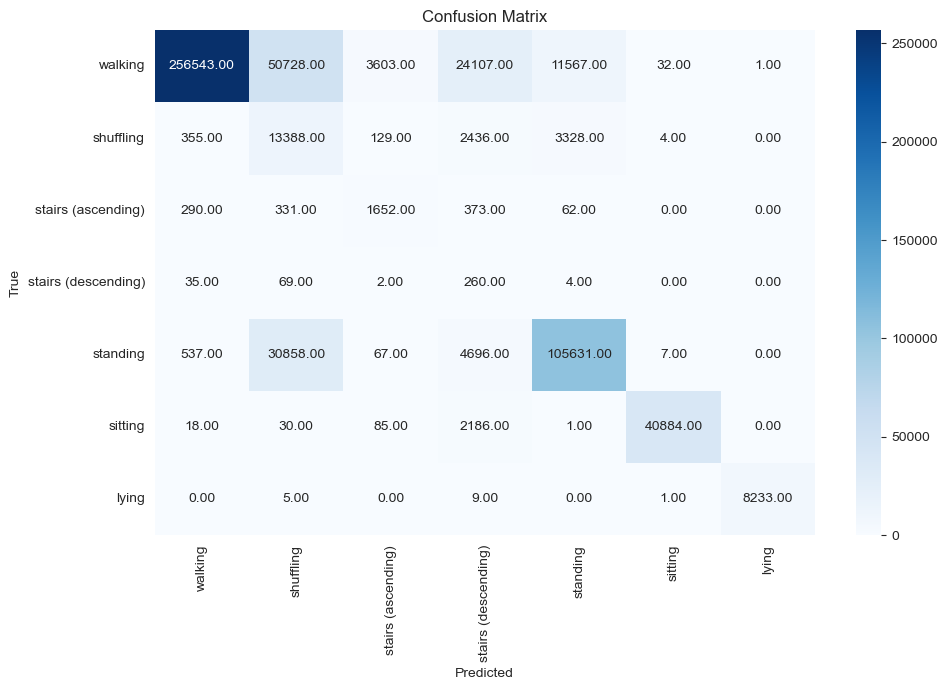

In [44]:
# Let's plot the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test_decoded_fourier, y_pred_decoded_fourier)

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

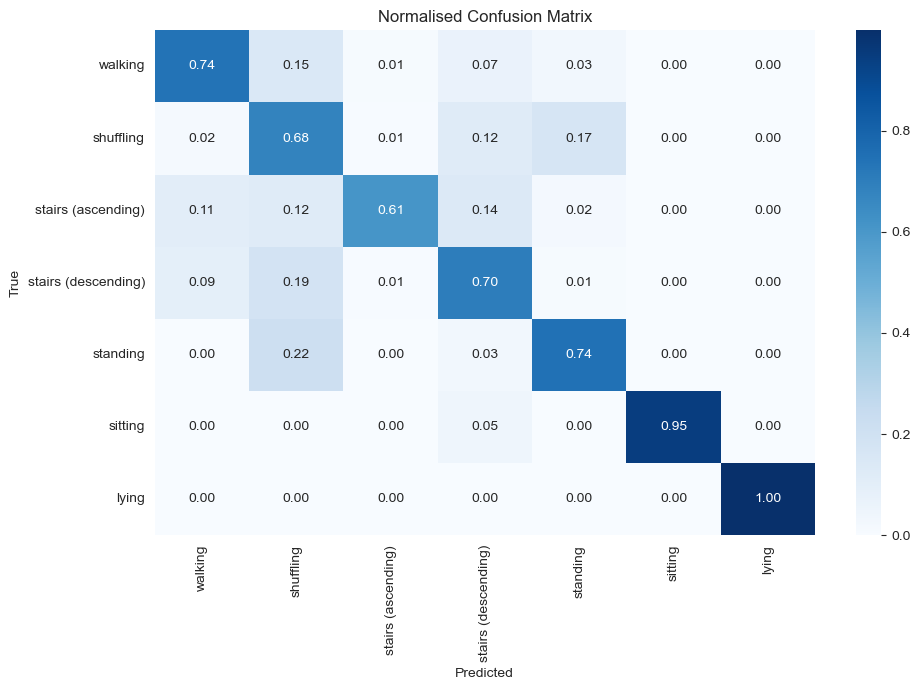

In [45]:
# Let's also print the normalised confusion matrix due to the class imbalance
norm_conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))

sns.heatmap(norm_conf_matrix, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')

plt.tight_layout()
plt.show()

In [46]:
# Finally, let's print the classification report for the best model
print(classification_report(y_test_decoded_fourier, y_pred_decoded_fourier))

              precision    recall  f1-score   support

           1       1.00      0.74      0.85    346581
           3       0.14      0.68      0.23     19640
           4       0.30      0.61      0.40      2708
           5       0.01      0.70      0.02       370
           6       0.88      0.74      0.81    141796
           7       1.00      0.95      0.97     43204
           8       1.00      1.00      1.00      8248

    accuracy                           0.76    562547
   macro avg       0.62      0.77      0.61    562547
weighted avg       0.93      0.76      0.83    562547



In [47]:
# Let's pickle the best model for later use
import pickle

with open('basicESN_har70_augments.pkl', 'wb') as f:
    pickle.dump(basic_esn_fourier, f)
    
    